## Fig. 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
import scipy
import gmpy2
import scipy.stats as st
import scipy.special as sp
from scipy.interpolate import interp1d
from scipy.integrate import quad
from itertools import count, product
import importlib
import matplotlib.font_manager
import mpmath
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
from matplotlib import rc

mpl.rcParams['figure.dpi']= 500
sns.set_style("ticks")
rc('text', usetex=False)
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({"font.family":"Liberation Serif", 'mathtext.fontset': 'cm'})#Times New Roman"})

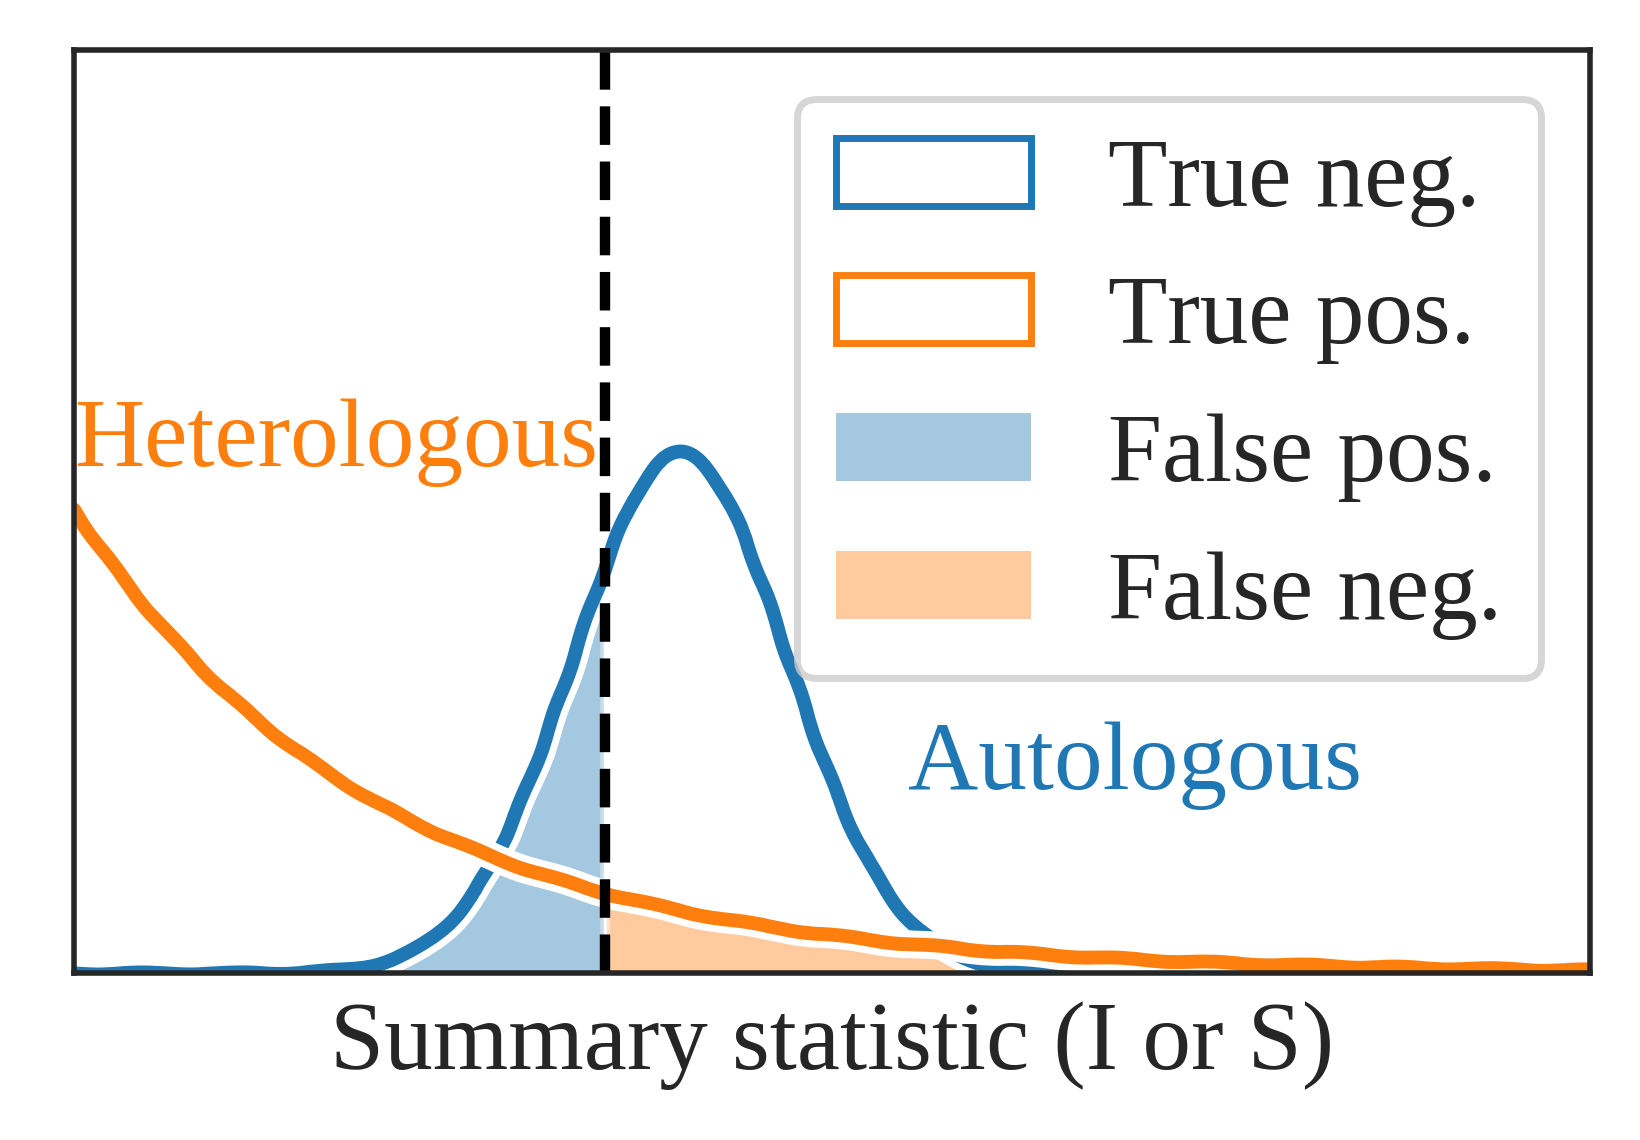

In [2]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.text(0.0, 0.55,'Heterologous', color=sns.color_palette()[1], transform=ax.transAxes)
ax.text( 0.55, 0.2,'Autologous', color=sns.color_palette()[0], transform=ax.transAxes)


xs = np.arange(0, 10, 0.01)
poi = np.exp(-xs/2)
poi /= np.sum(poi)
gau = np.exp(-(xs - 4.)**2/1)
gau /= np.sum(gau)

with plt.xkcd():
    ax.plot(xs, gau, label="True positive", color=sns.color_palette()[0])
    ax.plot(xs, poi, label="True negative", color=sns.color_palette()[1])


from matplotlib.patches import Patch

#res = scipy.optimize.minimize(lambda x: np.abs(
#    np.exp(-(x - 4.)**2/1) - np.exp(-x/1)), 2)
y = 3.5
ax.axvline(y, c='k', ls='--')

mpl.rcParams['hatch.linewidth'] = 2


ax.fill_between([x for x, p in zip(xs, poi) if x > y],
        [p for x, p in zip(xs, poi) if x > y],  facecolor=sns.color_palette()[1], alpha=0.4)

ax.fill_between([x for x, p in zip(xs, gau) if x < y],
        [p for x, p in zip(xs, gau) if x < y],  facecolor=sns.color_palette()[0], alpha=0.4)


legend_elements = [Patch(facecolor='white', 
                         edgecolor=sns.color_palette()[0],
                         label='True neg.'),
                  Patch(facecolor='white', 
                         edgecolor=sns.color_palette()[1],
                         label='True pos.'),
                  Patch(facecolor=sns.color_palette()[0],
                         edgecolor='none',
                         alpha=0.4,
                         label='False pos.'),
                  Patch(facecolor=sns.color_palette()[1], 
                         edgecolor='none',
                         alpha=0.4,
                         label='False neg.')]

ax.legend(handles=legend_elements)
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.01)
ax.set_xlabel("Summary statistic (I or S)")
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.savefig("fig1b.pdf")
plt.show()

In [3]:
# estimate pgen(a,b) for shared & non-shared
dfb, dfa = {}, {}
for patient in ["1", "3", "4"]:
    dfb[patient] = pd.read_csv(f"../datasets/consensus_annotation_{patient}_pgen_trb.csv.gz", 
               sep="\t")
    dfb[patient]["patient"] = patient
    dfa[patient] = pd.read_csv(f"../datasets/consensus_annotation_{patient}_pgen_tra.csv.gz",
               sep="\t")
    dfa[patient]["patient"] = patient


allb = pd.concat([dfb[k].groupby("ntCDR3").pgen_nt.first().to_frame().reset_index() for k in dfb], axis=0)
alla = pd.concat([dfa[k].groupby("ntCDR3").pgen_nt.first().to_frame().reset_index() for k in dfb], axis=0)

allb["pgennt"] = allb["pgen_nt"]
alla["pgennt"] = alla["pgen_nt"]

allb = allb.groupby("ntCDR3").agg({"pgennt": "first", "ntCDR3": "count"})
allb = allb[allb.pgennt > 1e-50]


alla = alla.groupby("ntCDR3").agg({"pgennt": "first", "ntCDR3": "count"})
alla = alla[alla.pgennt > 1e-50]


## estimate the distribution of pgen
dE = 0.5
Emin, Emax = 0, 100
Es = np.arange(Emin, Emax, dE)
hista, bin_edges = np.histogram(-np.log(alla.pgennt), bins=(list(Es - dE/2) + [Es[-1] + dE/2]), density=True)
pEalpha = interp1d(Es, hista, fill_value=0, bounds_error=False)
histb, bin_edges = np.histogram(-np.log(allb.pgennt), bins=(list(Es - dE/2) + [Es[-1] + dE/2]), density=True)
pEbeta = interp1d(Es, histb, fill_value=0, bounds_error=False)

xs = np.arange(Emin, Emax, dE/10)
f = 0.236
q = 0.03

meanS =  (quad(lambda E: pEbeta(E - np.log(f*q)) * np.exp(-E),
                       Emin, Emax, 
                       limit=300, full_output=True)[0] 
                   /
                   quad(lambda E: pEbeta(E - np.log(f*q)), 
                        Emin, Emax, limit=300, full_output=True)[0])

meanI =  (quad(lambda E: pEbeta(E - np.log(f*q)) * np.exp(-E) * (E - np.log(f*q)),
                       Emin, Emax, 
                       limit=300, full_output=True)[0] 
                   /
                   quad(lambda E: pEbeta(E - np.log(f*q)), 
                        Emin, Emax, limit=300, full_output=True)[0])


NameError: name 'γ' is not defined

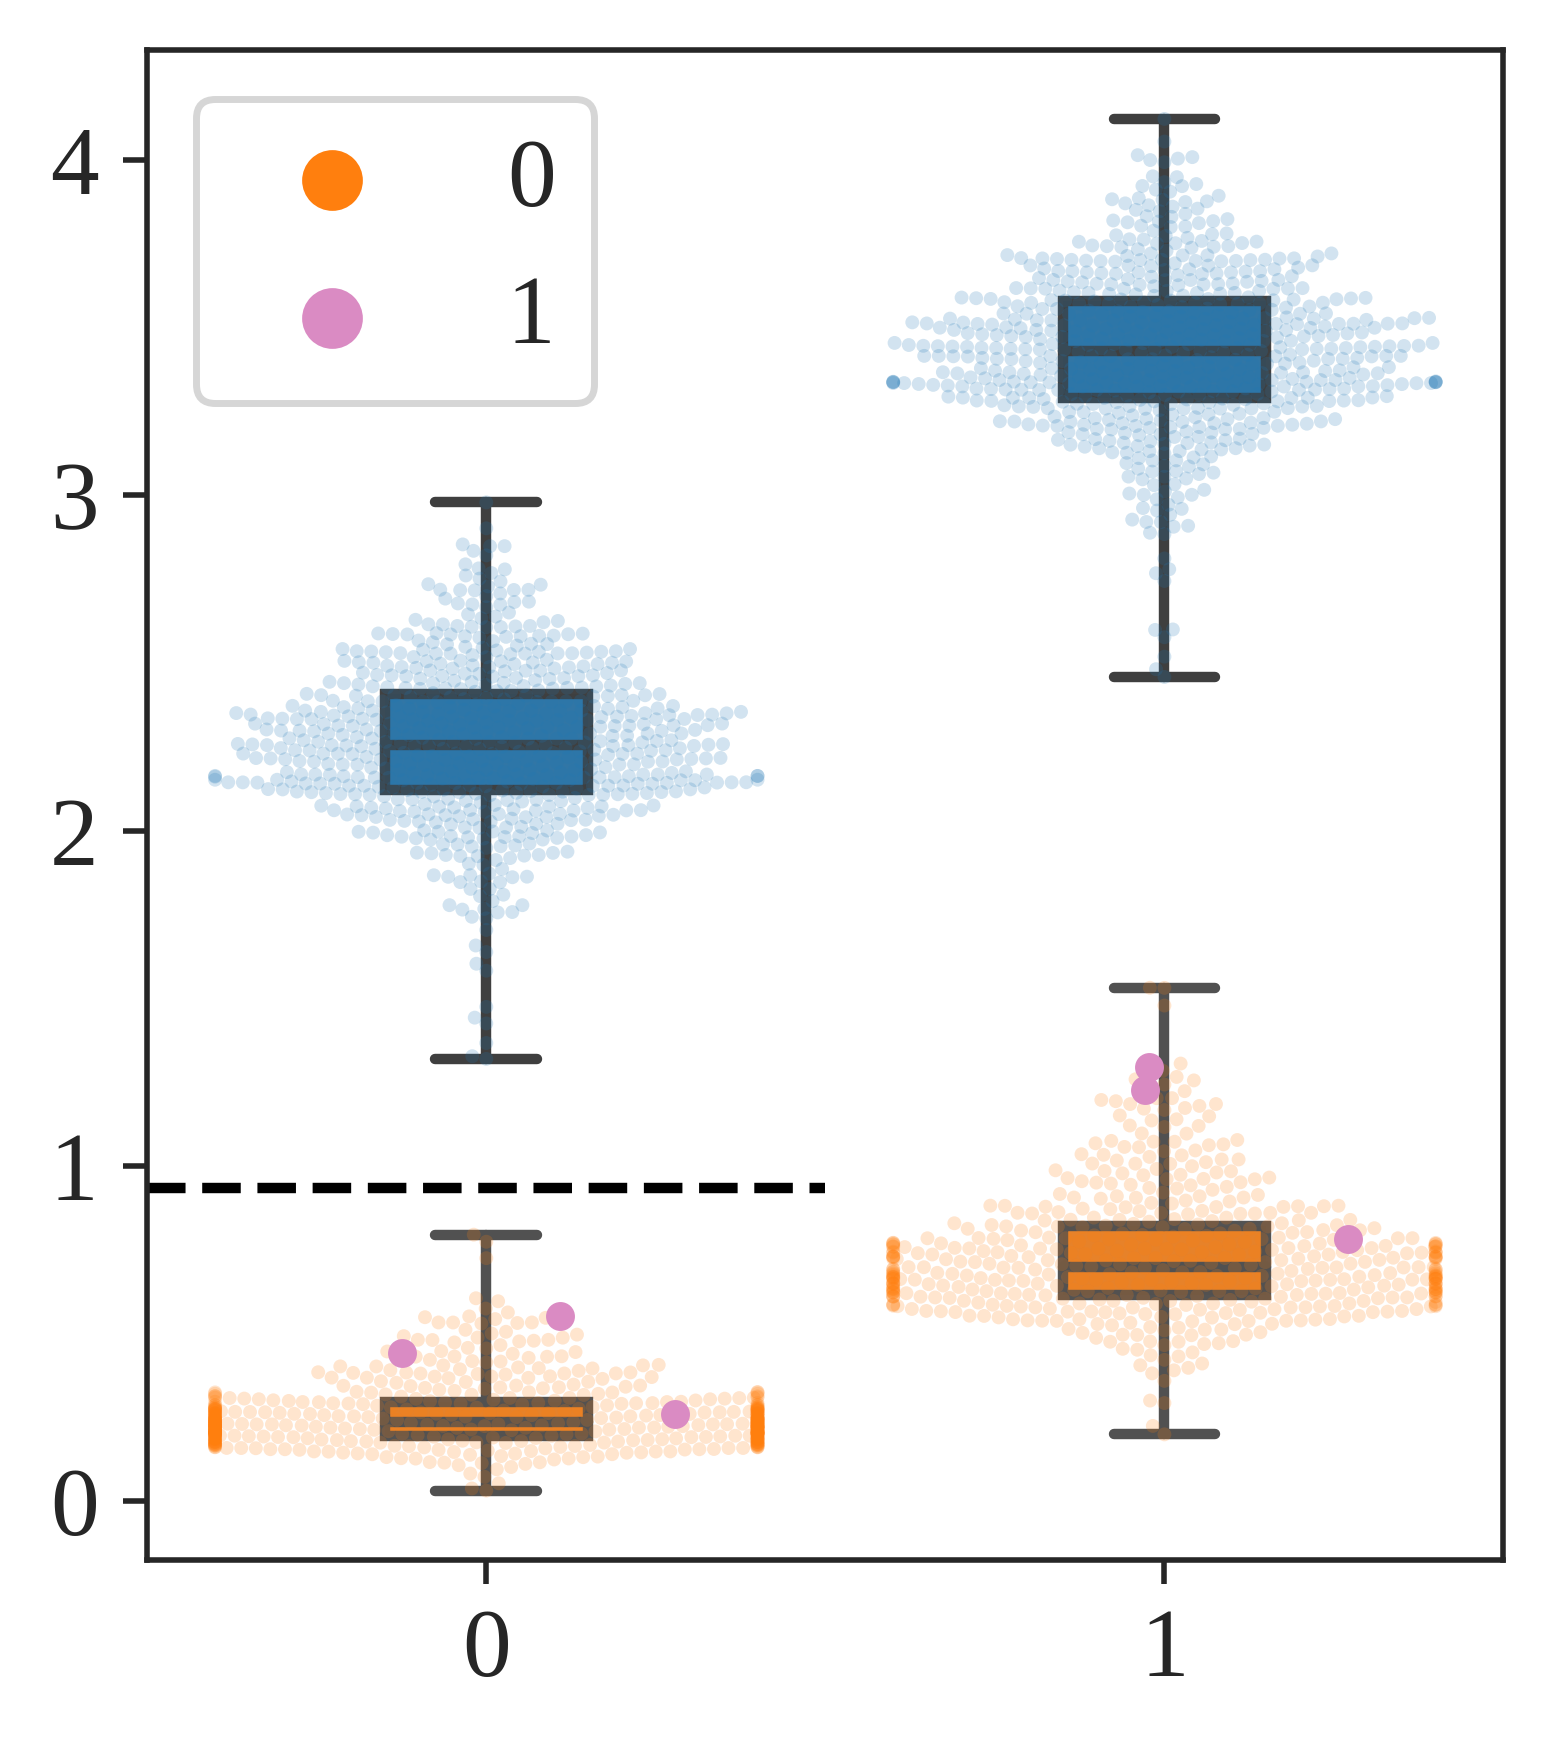

In [5]:
# loading the value of S & I for the Emerson dataset & the YFV dataset
with open("../datasets/means_SI_M5000_g12.pkl", 'rb') as f:
    val, val2, valI, valI2, twin_pos = pickle.load(f)

fig, ax = plt.subplots(figsize=(3.5, 4))
    
valI = np.log10(1 + valI)
valI2 = np.log10(1 + valI2)
val = np.log10(1 + val)
val2 = np.log10(1 + val2)

twin_color = "#DA8BC3"
dfg = pd.read_csv("../datasets/all_pairs_different_S_I.csv.gz")

sns.swarmplot(x=[0]*len(val) + [1] * len(valI), 
              y=list(val) + list(valI),
              color=sns.color_palette()[0], size=2, alpha=0.2, ax=ax, zorder=10)
sns.boxplot(x=[0]*len(val)+ [1] * len(valI), 
            y=list(val) + list(valI), boxprops=dict(alpha=.99), 
            saturation=0.8, whis="range", width=0.3, 
            color=sns.color_palette()[0], ax=ax,zorder=8)

flatui = [sns.color_palette()[1], twin_color]
sp = sns.swarmplot(x=[0]*len(val2) + [1]*len(valI2), 
              y=list(val2) + list(valI2),
              hue=list(twin_pos),
              palette=sns.color_palette(flatui),
              s=2, alpha=0.2,zorder=9)
for ii in [2, 3]:
    c = sp.collections[ii].get_facecolor()
    x,y = np.array(sp.collections[ii].get_offsets()).T
    tws = np.isclose(c[:, 0], int(flatui[1][1:3], 16)/255)
    ax.scatter(x[tws], y[tws], color=twin_color, s=10, zorder=10000*ii)
    
sns.boxplot(x=[0]*len(val2) + [1]*len(valI2), 
            y=list(val2) + list(valI2), boxprops=dict(alpha=.99), 
            saturation=0.8, whis="range", width=0.3, 
            color=sns.color_palette()[1], ax=ax, zorder=6)

ax.plot([-0.5, 0.5], 
        [np.log10(1+x) for x in [meanS*5000**2]*2],
        linestyle="--",
        color="k")

ax.plot([0.5, 1.5], 
        [np.log10(1+x) for x in [(meanI + γ*meanS) * 5000**2]*2],
        linestyle="--",
        color="k")

ticks = [a for a in range(5)]
ax.set_yticks([0] + [np.log10(1 + 10**a) for a in ticks])
ax.set_yticklabels(["0"] + [f"$10^{{{a}}}$" for a in ticks])
ax.set_xlim((-0.5, 1.5))
ax.set_xticks([0, 1])
ax.set_xticklabels([r"$\langle S \rangle$", r"$\langle I \rangle$"])


ax.legend().remove()
plt.tight_layout()
plt.savefig("fig1c.pdf")
plt.show()

(array([502, 506, 508]),) 515 515


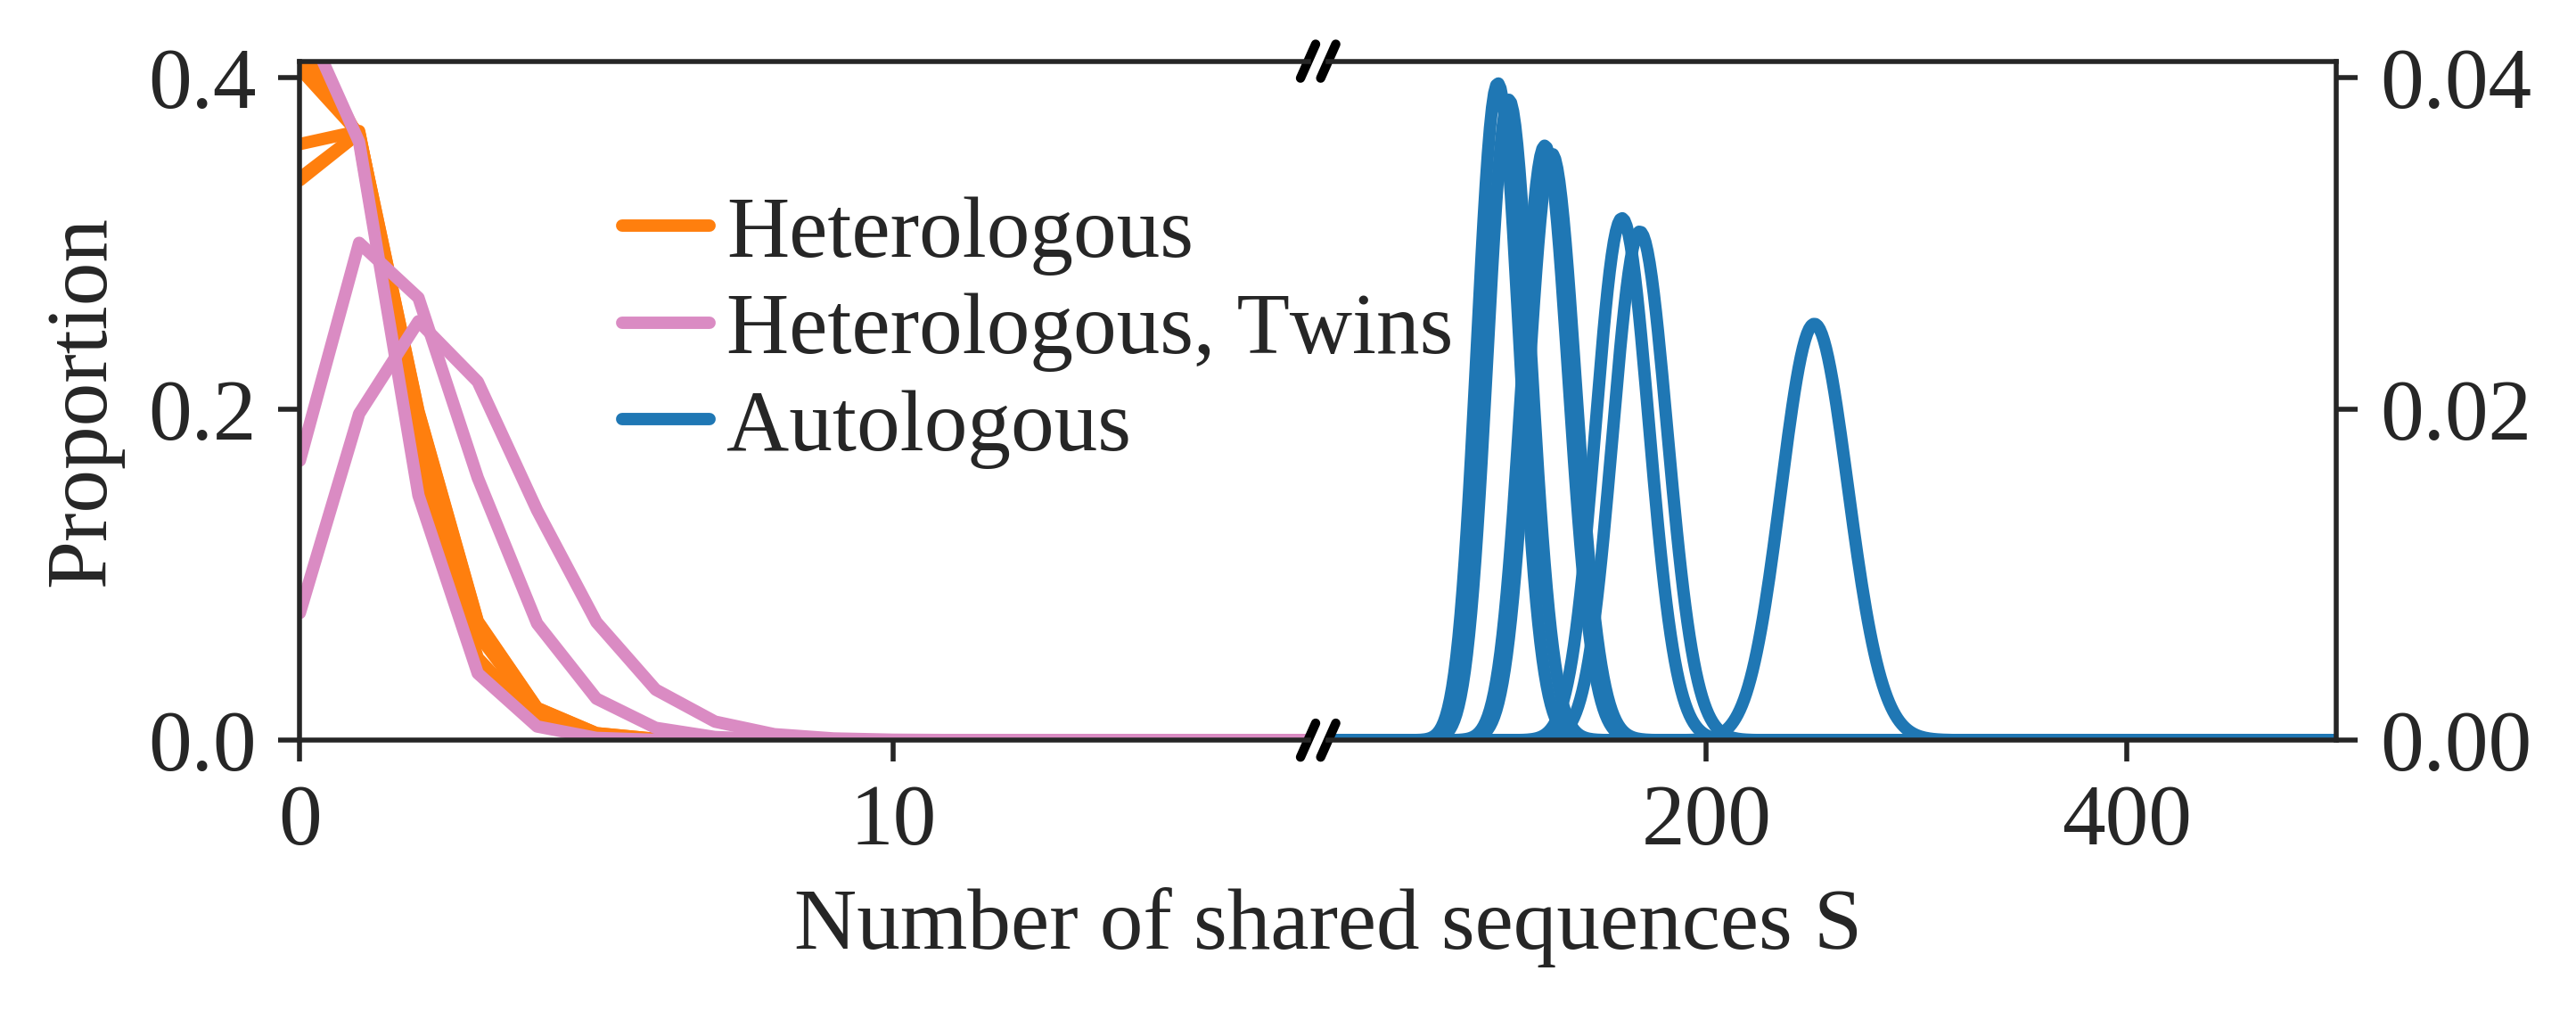

In [46]:
def plot_poisson(m, ax, color="k", label=None, alpha=1, lw=1):
    rg = np.arange(0, int(40*m))
    ax.plot(rg, [scipy.stats.poisson.pmf(k, m) for k in rg], 
            color=color, # drawstyle='steps-post', 
            label=label, alpha=alpha,
            linewidth=lw)

# loading the value of S & I for the Emerson dataset & the YFV dataset
with open("../datasets/means_SI_M5000_g12.pkl", 'rb') as f:
    val, val2, _, _, twin_pos = pickle.load(f)
    val = np.array(val)
    val2 = np.array(val2)
    twin_pos = np.array(twin_pos)[:len(val2)]

Ss_a = val[-7:]
print(np.where(twin_pos), len(twin_pos), len(val2))
Ss_h = val2[np.where(~twin_pos)][-6:]

Ss_h_twins = val2[np.where(twin_pos)]

twin_color = "#DA8BC3"
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(6, 2.5), sharey=False, facecolor='w')

for s in Ss_a:
    plot_poisson(s, ax2, 
                 color=sns.color_palette()[0], alpha=1., lw=2) 
for s in Ss_h:
    plot_poisson(s, ax1, 
                 color=sns.color_palette()[1], alpha=1., lw=2) 
for s in Ss_h_twins:
    plot_poisson(s, ax1, 
                 color=twin_color, alpha=1., lw=2)
            
       
ax1.set_xlim(0,17)
ax1.set_ylim(0, 0.41)
ax2.set_xlim(20,500)
ax2.set_ylim(0, 0.041)

# hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labelright=False)
ax2.yaxis.tick_right()
ax1.set_ylabel('Proportion')

d = .025
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d*0.3,1+d*0.3), (-d,+d), **kwargs)
ax1.plot((1-d*0.3,1+d*0.3),(1-d,1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d*0.3,+d*0.3), (1-d,1+d), **kwargs)
ax2.plot((-d*0.3,+d*0.3), (-d,+d), **kwargs)
ax2.set_xlabel("Number of shared sequences S", x=0)
lines = [Line2D([0], [0], color=[sns.color_palette()[1], twin_color, sns.color_palette()[0]][ii],
                linewidth=2, linestyle='-', alpha=1., marker=None) for ii in range(3)]
labels = ["Heterologous", "Heterologous, Twins", "Autologous"]
leg = Legend(ax2, lines, labels,  frameon=False, handlelength=1,
          handletextpad=0.2, labelspacing=0.2, borderpad=0., loc=(-0.7, 0.4))
ax2.add_artist(leg)

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.savefig("fig2a.pdf")
plt.show()

In [6]:
## Fig 2b
import gmpy2
mpmath.mp.dps = 400 # increase precision


## The means of S(A, B) can be estimated from data
## We also make the assumption that the growth of the mean is 
## roughly M^2 (not necessary, but backed by data)

# mean of S if the 2 samples are autologous (scenario 1)
meanS1 = lambda M: 19.9/(5000**2) * M**2

# mean of S if the 2 samples are *not* autologous (scenario 2)
meanS2 = lambda M: meanS * M**2 #0.35/(1000**2) 
# mean of S if the 2 samples are *not* autologous (scenario 2, with both alpha & beta)
meanS2ab = lambda M: 1e-7/(1000**2) * M**2
µp2 = 17.8 # mean of the log(pgen) distribution, for shared sequences
σp2 = 2.04 # standard deviation of the log(pgen) distribution, for shared sequences
µp = 26.0 # mean of the log(pgen) distribution
σp = 5.8 # standard deviation of the log(pgen) distribution
µp2ab = 33 
σp2ab = 3
µpab = 47
σpab = 8

def boundI1(r, M, meanS1=meanS1, µp=µp, σp=σp, maxM=None):
    """ return an upper bound for P[I(A, B) < r | A&B autologous] """
    λ = gmpy2.mpfr(meanS1(M)) # parameter of the poisson law
    if maxM is None:
        maxM = M
    ks = range(1, maxM)
    poiss = [λ**k/gmpy2.fac(k) * gmpy2.exp(-λ) for k in ks]
    norms =  [1/2*(1 + gmpy2.erf((r - μp * k)/(gmpy2.sqrt(2 * k) * σp))) for k in ks]
        #scipy.stats.norm.cdf(r, loc=µp*ks, scale=σp*np.sqrt(ks))
    # add the k=0 term (no CDR3 shared)
    if r <= 0:
        return gmpy2.mpfr(0.)
    else:
        return (gmpy2.fsum([p * n for p, n in zip(poiss, norms)]) + 
                gmpy2.exp(-λ))

def boundI2(r, M, meanS2=meanS2, µp=µp2, σp=σp2, maxM=None):
    """ return an upper bound for P[I(A, B) >= r | A&B not autologous] """
    λ = gmpy2.mpfr(meanS2(M)) # parameter of the poisson law
    if maxM is None:
        maxM = M
    ks = range(0, maxM)
    poiss =  [gmpy2.exp(-λ)/gmpy2.fac(k) * λ**k for k in ks]
    norms = [1/2*(1 + gmpy2.erf((r - μp * k)/(gmpy2.sqrt(2 * k) * σp))) 
             if k > 0 else 1 for k in ks]

    if r > 0:
        return gmpy2.fsum([p * (1-n) for p, n in zip(poiss, norms)])
    else:
        return gmpy2.mpfr(1.)


def trpz_gmpy(x, y):
    x, y = zip(*sorted(zip(x, y)))
    return gmpy2.fsum( (b-a) * (fa + fb)/2 for a,b,fa,fb in zip(x[:-1], x[1:], y[:-1], y[1:]))

def regularized_gamma_Q(n, mu):
    return mpmath.gammainc(n, a=mu, regularized=True)



In [ ]:
γ = -12

mpmath.mp.dps = 50 # increase precision
Ms = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000, 10000]
tprS = defaultdict(list)
fprS = defaultdict(list)
fnrS = defaultdict(list)

for M in tqdm(Ms): # for different sample size
    for r in range(0, M//2): # for various thresholds r
        false_negative = regularized_gamma_Q(r+1, meanS1(M))
        true_negative = regularized_gamma_Q(r+1, meanS2(M))
        false_positive = 1 - regularized_gamma_Q(r+1, meanS2(M))
        true_positive = 1 - regularized_gamma_Q(r+1, meanS1(M))

        tprS[M].append(true_positive/(false_negative + true_positive))
        fnrS[M].append(1 - true_positive/(false_negative + true_positive))
        fprS[M].append(false_positive/(true_negative + false_positive))


    
Ms = [500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 8000, 10000]
tprI = defaultdict(list)
fprI = defaultdict(list)
fnrI = defaultdict(list)



for M in tqdm(Ms): # for different sample size
    for r in np.arange(1, M*30): # for various thresholds r
        # all already "normalized"
        false_negative = boundI1(r, M, µp=µp+γ, maxM=100)
        true_negative = 1 - boundI2(r, M, µp=µp2+γ, maxM=100)
        false_positive = boundI2(r, M, µp=µp2+γ, maxM=100)
        true_positive = 1 - boundI1(r, M, µp=µp+γ, maxM=100)
        tprI[M].append(true_positive)
        fnrI[M].append(false_negative)
        fprI[M].append(false_positive)
        if false_positive < 1e-30:
            break

<ipython-input-56-9666b7d7197f>:16: RuntimeWarning: invalid value encountered in log10
  ax.plot([np.log10(1e-100 + float(x)) for x in fprS[M]],


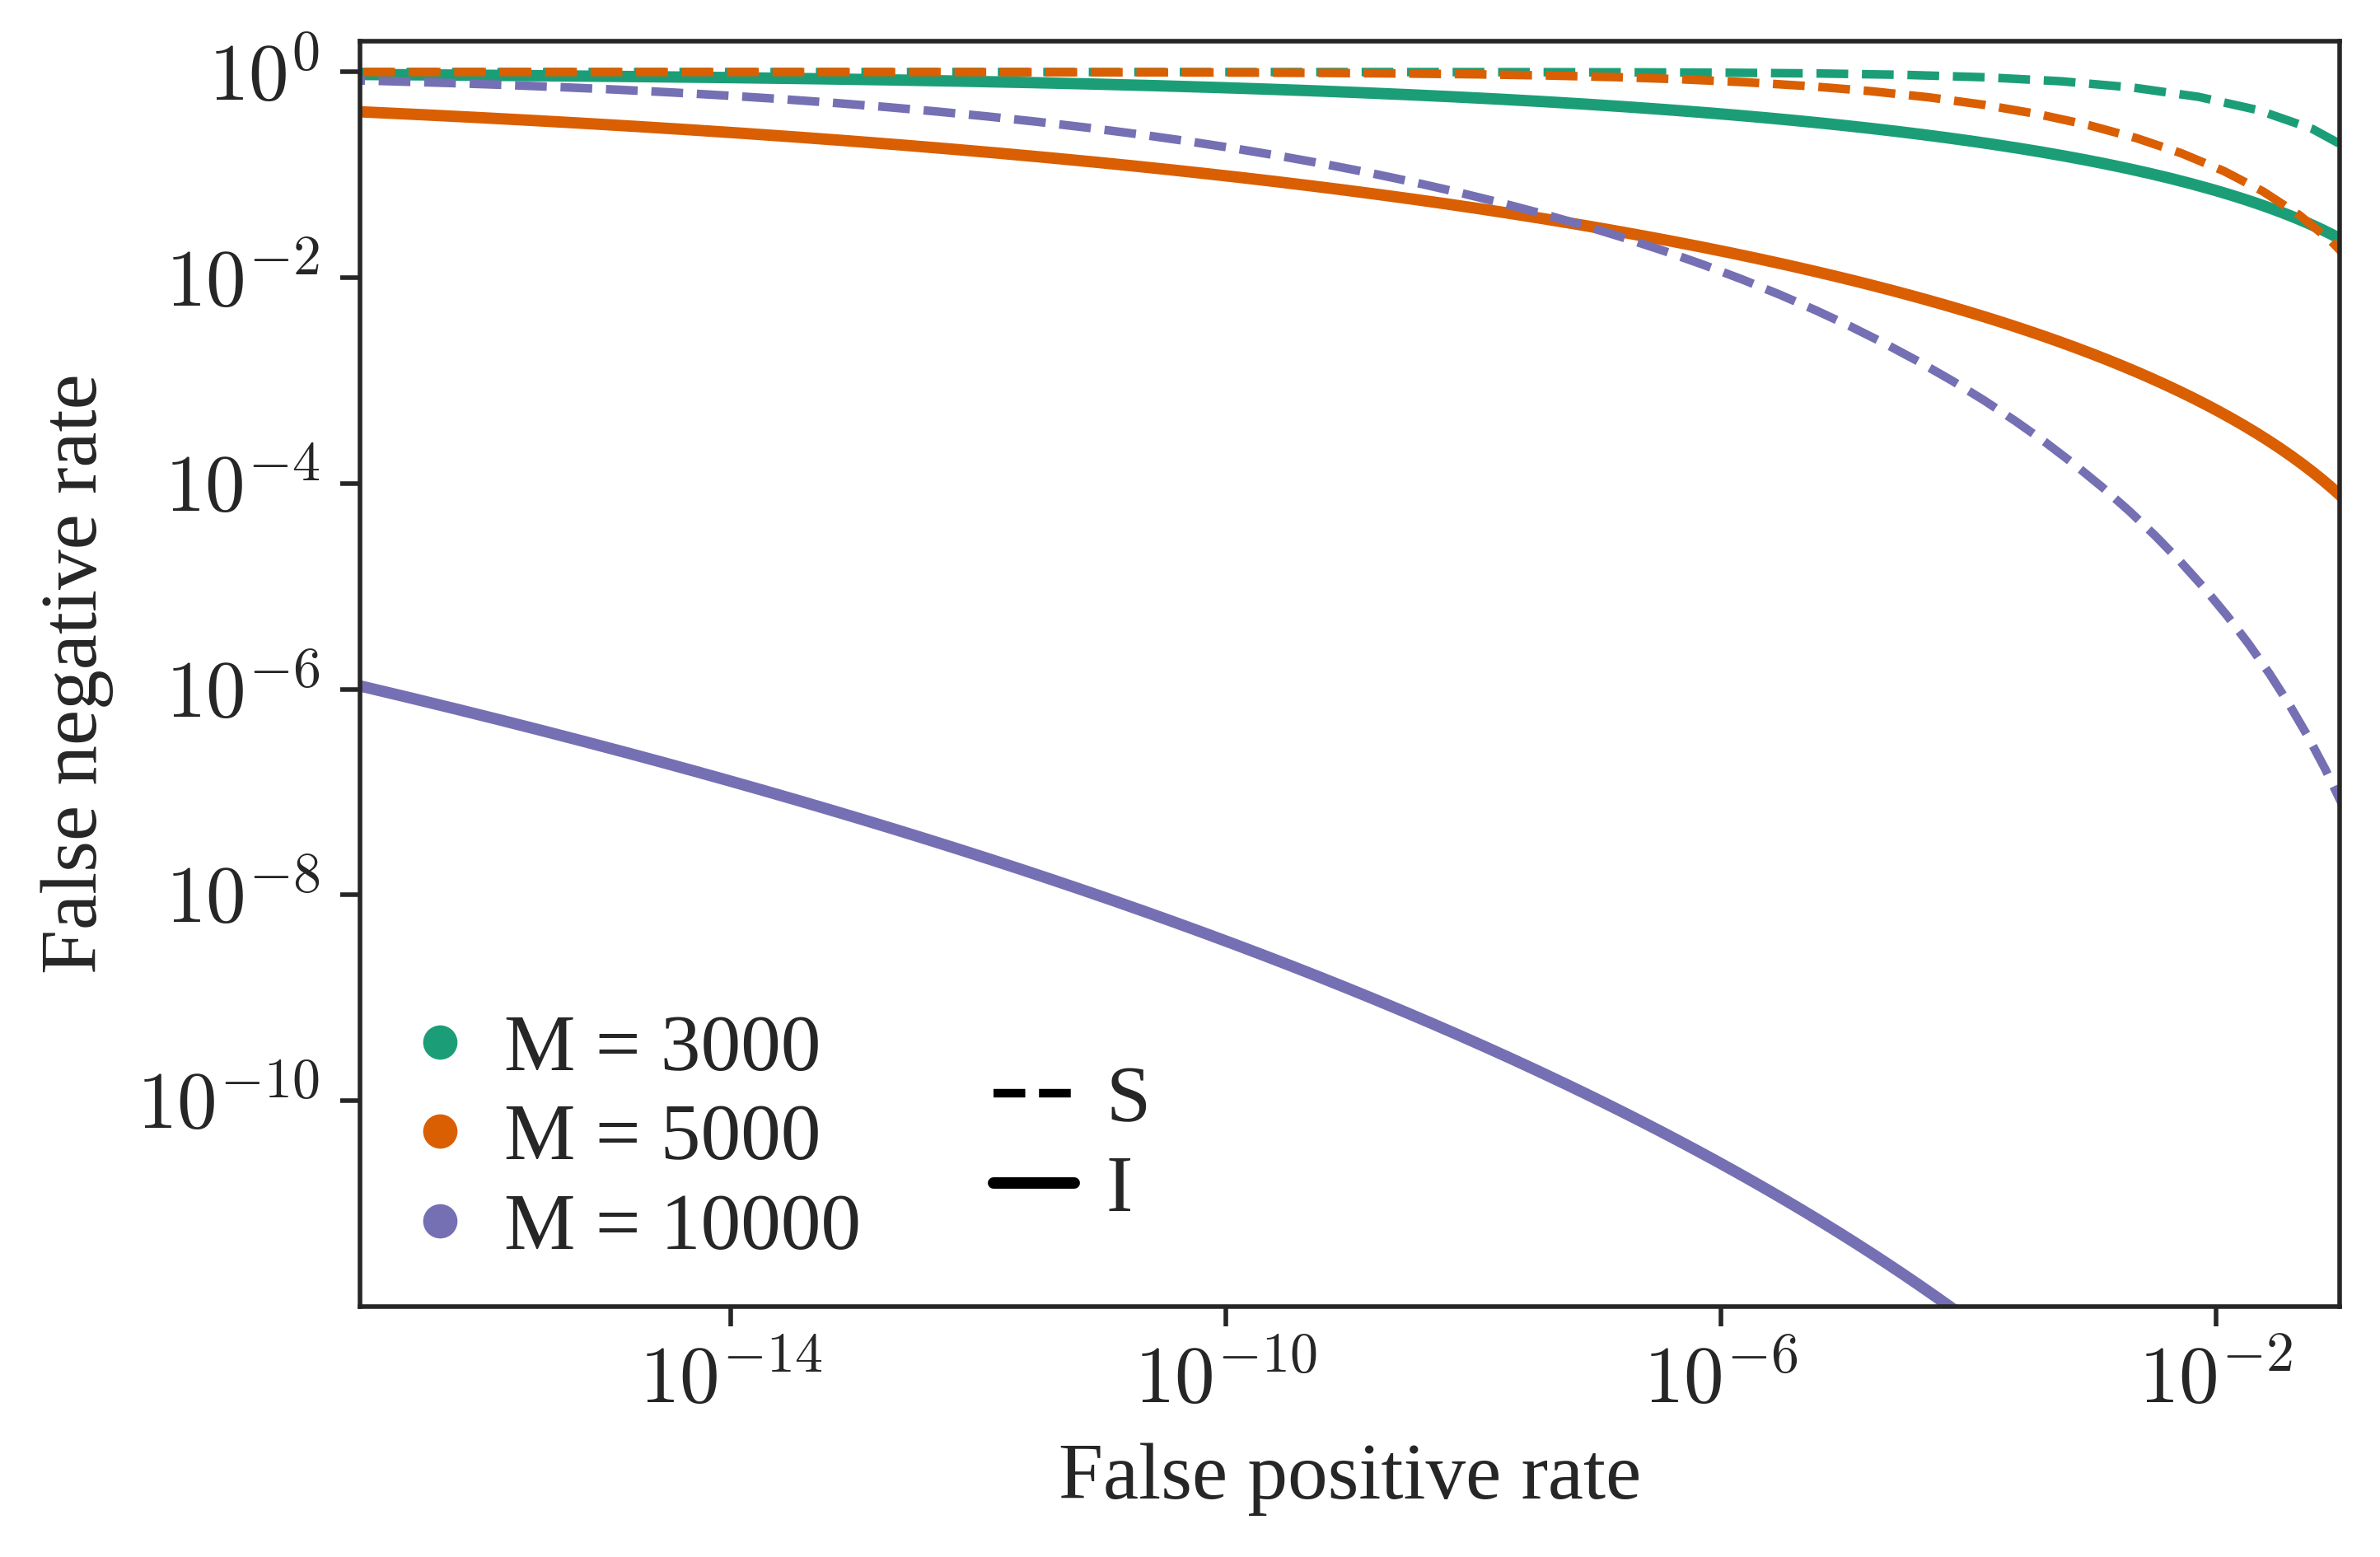

In [56]:

Ms = [3000, 5000, 10000]
lw = 2
flatui = ['#1b9e77','#d95f02','#7570b3']
pal = sns.color_palette(flatui)

fig, ax = plt.subplots(figsize=(6, 4))

linesS, linesI = [], []
for ii, M in enumerate(Ms):
    fprI[M], fnrI[M] = zip(*sorted(zip(fprI[M], fnrI[M])))
    fprS[M], fnrS[M] = zip(*sorted(zip(fprS[M], fnrS[M])))
    ax.plot([np.log10(float(x)) for x in fprI[M]], 
            [np.log10(float(x)) for x in fnrI[M]], 
            color=pal[ii], linewidth=lw)

    ax.plot([np.log10(float(x)) for x in fprS[M]],
            [np.log10(float(x)) for x in fnrS[M]],
                        '--', ms=3, 
            color=pal[ii], label=f"{M}")

ax.set_yticks([a for a in range(-10, 1, 2)])
ax.set_yticklabels([f"$10^{{{a}}}$" for a in range(-10, 1, 2)])
ax.set_xticks([a for a in range(-26, 1, 4)])
ax.set_xticklabels([f"$10^{{{a}}}$" for a in range(-26, 1,  4)])

ax.set_ylim(-12, 0.3)
ax.set_xlim(-17, -1)

ax.set_xlabel("False positive rate")
ax.set_ylabel("False negative rate")

lines2 = [Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linewidth=lw)]
labels2 = ["S", "I"]
leg = Legend(ax, lines2, labels2, frameon=False, loc='lower left',
             bbox_to_anchor=(0.3, 0.03, 0.5, 0.5),
            handlelength=1,
          handletextpad=0.4, labelspacing=0.2, borderpad=0.)
ax.add_artist(leg)

lines1 = [Line2D([0], [0], color=pal[ii], linestyle='', marker='.', ms=10) for ii, _ in enumerate(Ms) ]
labels1 = [f"M = {M}" for M in Ms]
leg = Legend(ax, lines1, labels1, frameon=False, loc='lower left',
             bbox_to_anchor=(0., 0, 0.5, 0.5),
            handlelength=1,
          handletextpad=0.3, labelspacing=0.2, borderpad=0.)
ax.add_artist(leg)

plt.tight_layout()
plt.savefig("fig2b.pdf")
plt.show()


In [57]:
area_ROC_I = []
Ms = np.arange(100, 8000, 100)
for M in tqdm(Ms):
    area_ROC_I.append(trpz_gmpy(
        [boundI2(r, M, meanS2=meanS2, 
           µp=µp2+γ, σp=σp2, maxM=50) for r in range(-1, M+1)],
        [boundI1(r, M, µp=µp+γ, σp=σp, maxM=50) for r in range(-1, M+1)]))


area_ROC_Iab = []
Ms = np.arange(100, 8000, 100)
for M in tqdm(Ms):
    area_ROC_Iab.append(trpz_gmpy(
        [boundI2(r, M, meanS2=meanS2ab, 
           µp=µp2ab, σp=σp2ab, maxM=50) for r in range(-1, M+1)],
        [ boundI1(r, M, µp=µpab, σp=σpab, maxM=50) for r in range(-1, M+1)]))
               
area_ROC_S = []
Ms = list(range(1, 8000, 100))
for M in tqdm(Ms):
    area_ROC_S.append(
        1 - 
        np.trapz(
            y=[1 - regularized_gamma_Q(r+1, meanS1(M)) for r in range(-1, M+1)][::-1],
            x=[1 - regularized_gamma_Q(r+1, meanS2(M)) for r in range(-1, M+1)][::-1])
    )
    
area_ROC_Sab = []
Ms = np.arange(1, 8000, 100)
for M in tqdm(Ms):
    area_ROC_Sab.append(
        1 - 
        np.trapz(
            y=[1 - regularized_gamma_Q(r+1, meanS1(M)) for r in range(-1, M+1)][::-1],
            x=[1 - regularized_gamma_Q(r+1, meanS2ab(M)) for r in range(-1, M+1)][::-1])
    )

<ipython-input-58-67f79bfe2702>:15: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_Iab + [0]],


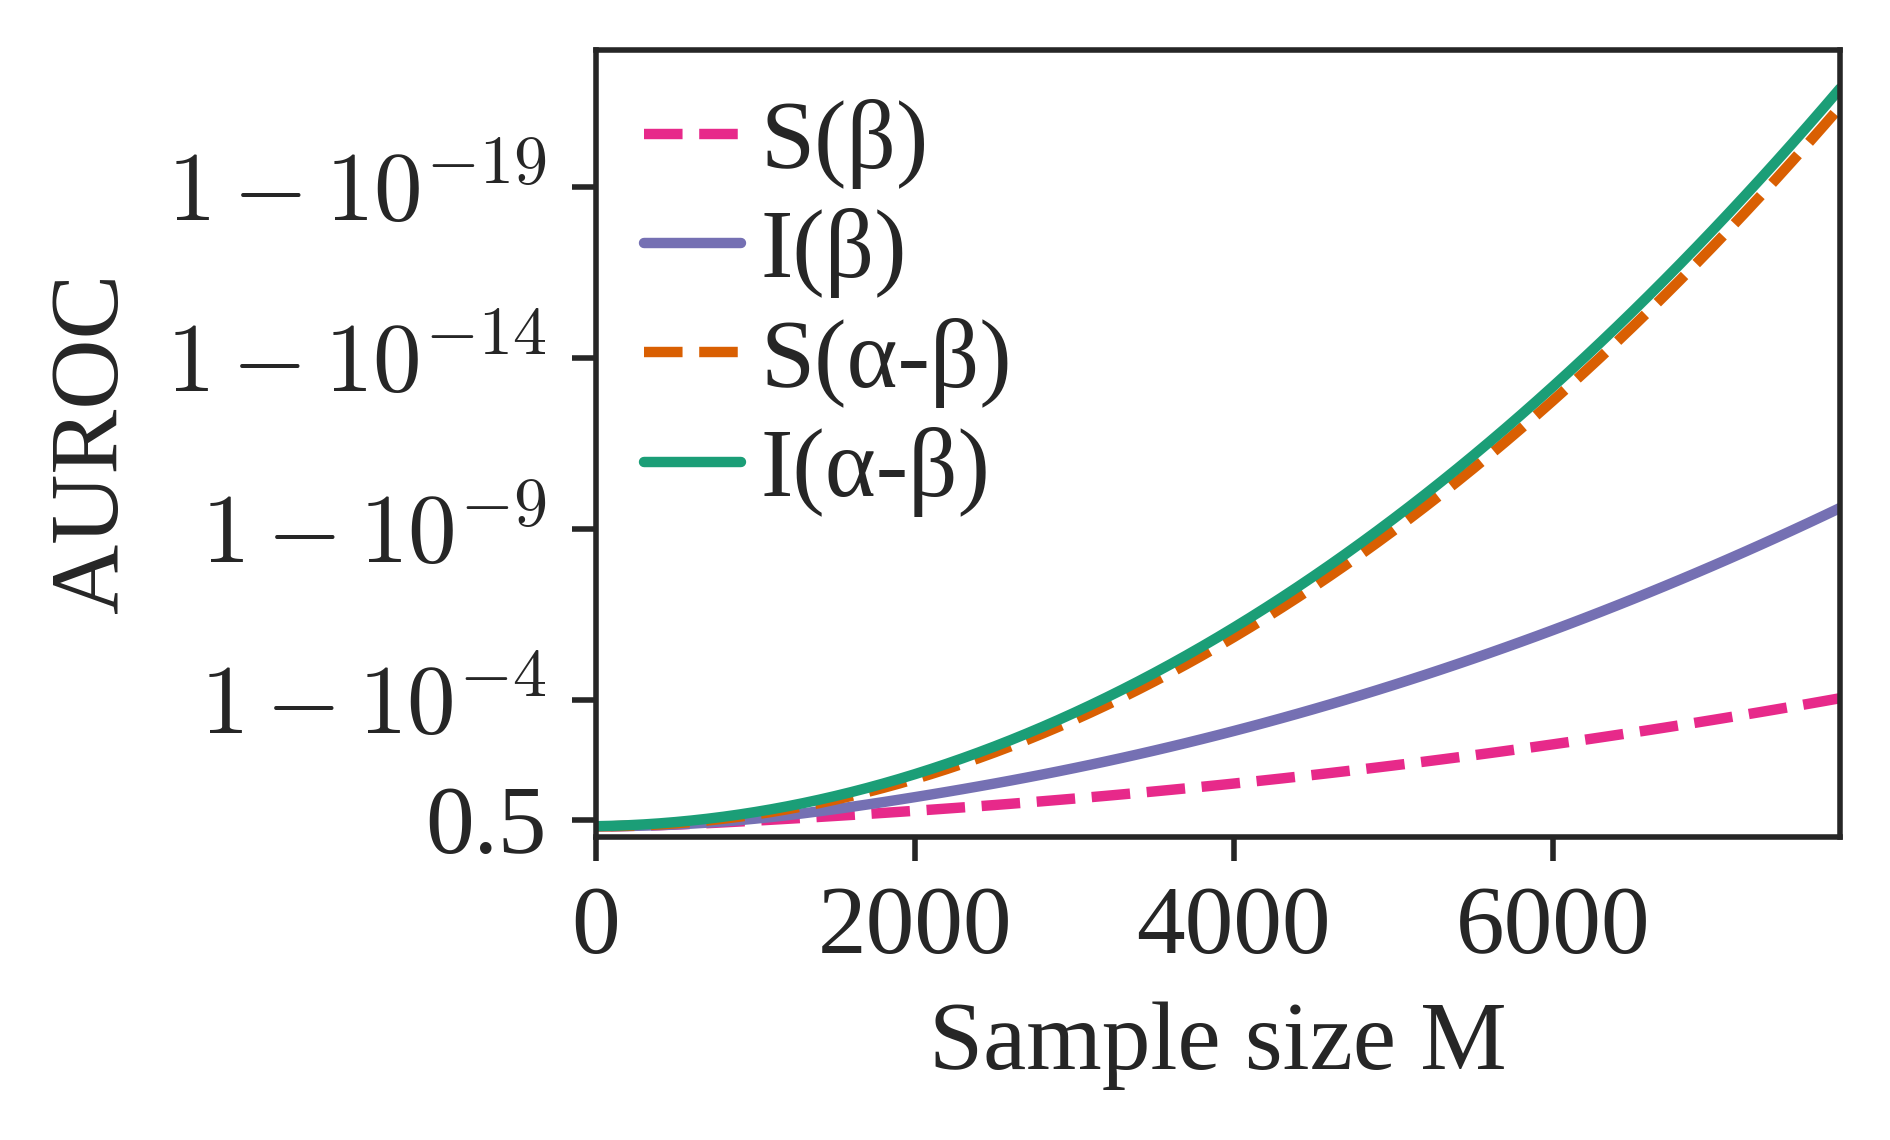

In [58]:
flatui = ['#e7298a','#7570b3','#d95f02','#1b9e77']
pal = sns.color_palette(flatui)

lw = 1.5
fig, ax = plt.subplots(figsize=(4, 2.5))

ax.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_S[:]], linestyle='--',
        label=r"S(β)", color=pal[0], linewidth=lw)
ax.plot(np.arange(100, 8000, 100), [-np.log10(float(v)) for v in area_ROC_I],
        label=r"I(β)", color=pal[1], linewidth=lw)
ax.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_Sab],  linestyle='--',
        label=r"S(α-β)", color=pal[2], linewidth=lw)
ax.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_Iab + [0]],
        label=r"I(α-β)", color=pal[3], linewidth=lw)

ax.set_yticks([-a for a in range(-69, -3, 5)] + [0.5])
ax.set_yticklabels([f"$1 - 10^{{{a}}}$" for a in range(-69, -3, 5)] + ["0.5"])
ax.set_ylim(0., 23)
ax.set_xlim(0, 7800)
ax.legend(loc='upper left', frameon=False, handlelength=1,
          handletextpad=0.2, labelspacing=0.2, borderpad=0.)
ax.set_ylabel(r"AUROC")
ax.set_xlabel(r"Sample size M")

plt.tight_layout()
plt.savefig("fig2c.pdf")
plt.show()

## Fig 2

In [62]:
# import pickle
# import matplotlib as mpl
# dft = pd.read_csv("YFV_SI_data.csv.gz")
# dft["patient"] = dft["patient"].apply(eval)
# dft = dft.set_index("patient")

with open("../datasets/pogorely_YF_SI.pkl", "rb") as f:
    Smean, Imean = pickle.load(f)

{'P1': 0, 'P2': 1, 'Q1': 2, 'Q2': 3, 'S1': 4, 'S2': 5}


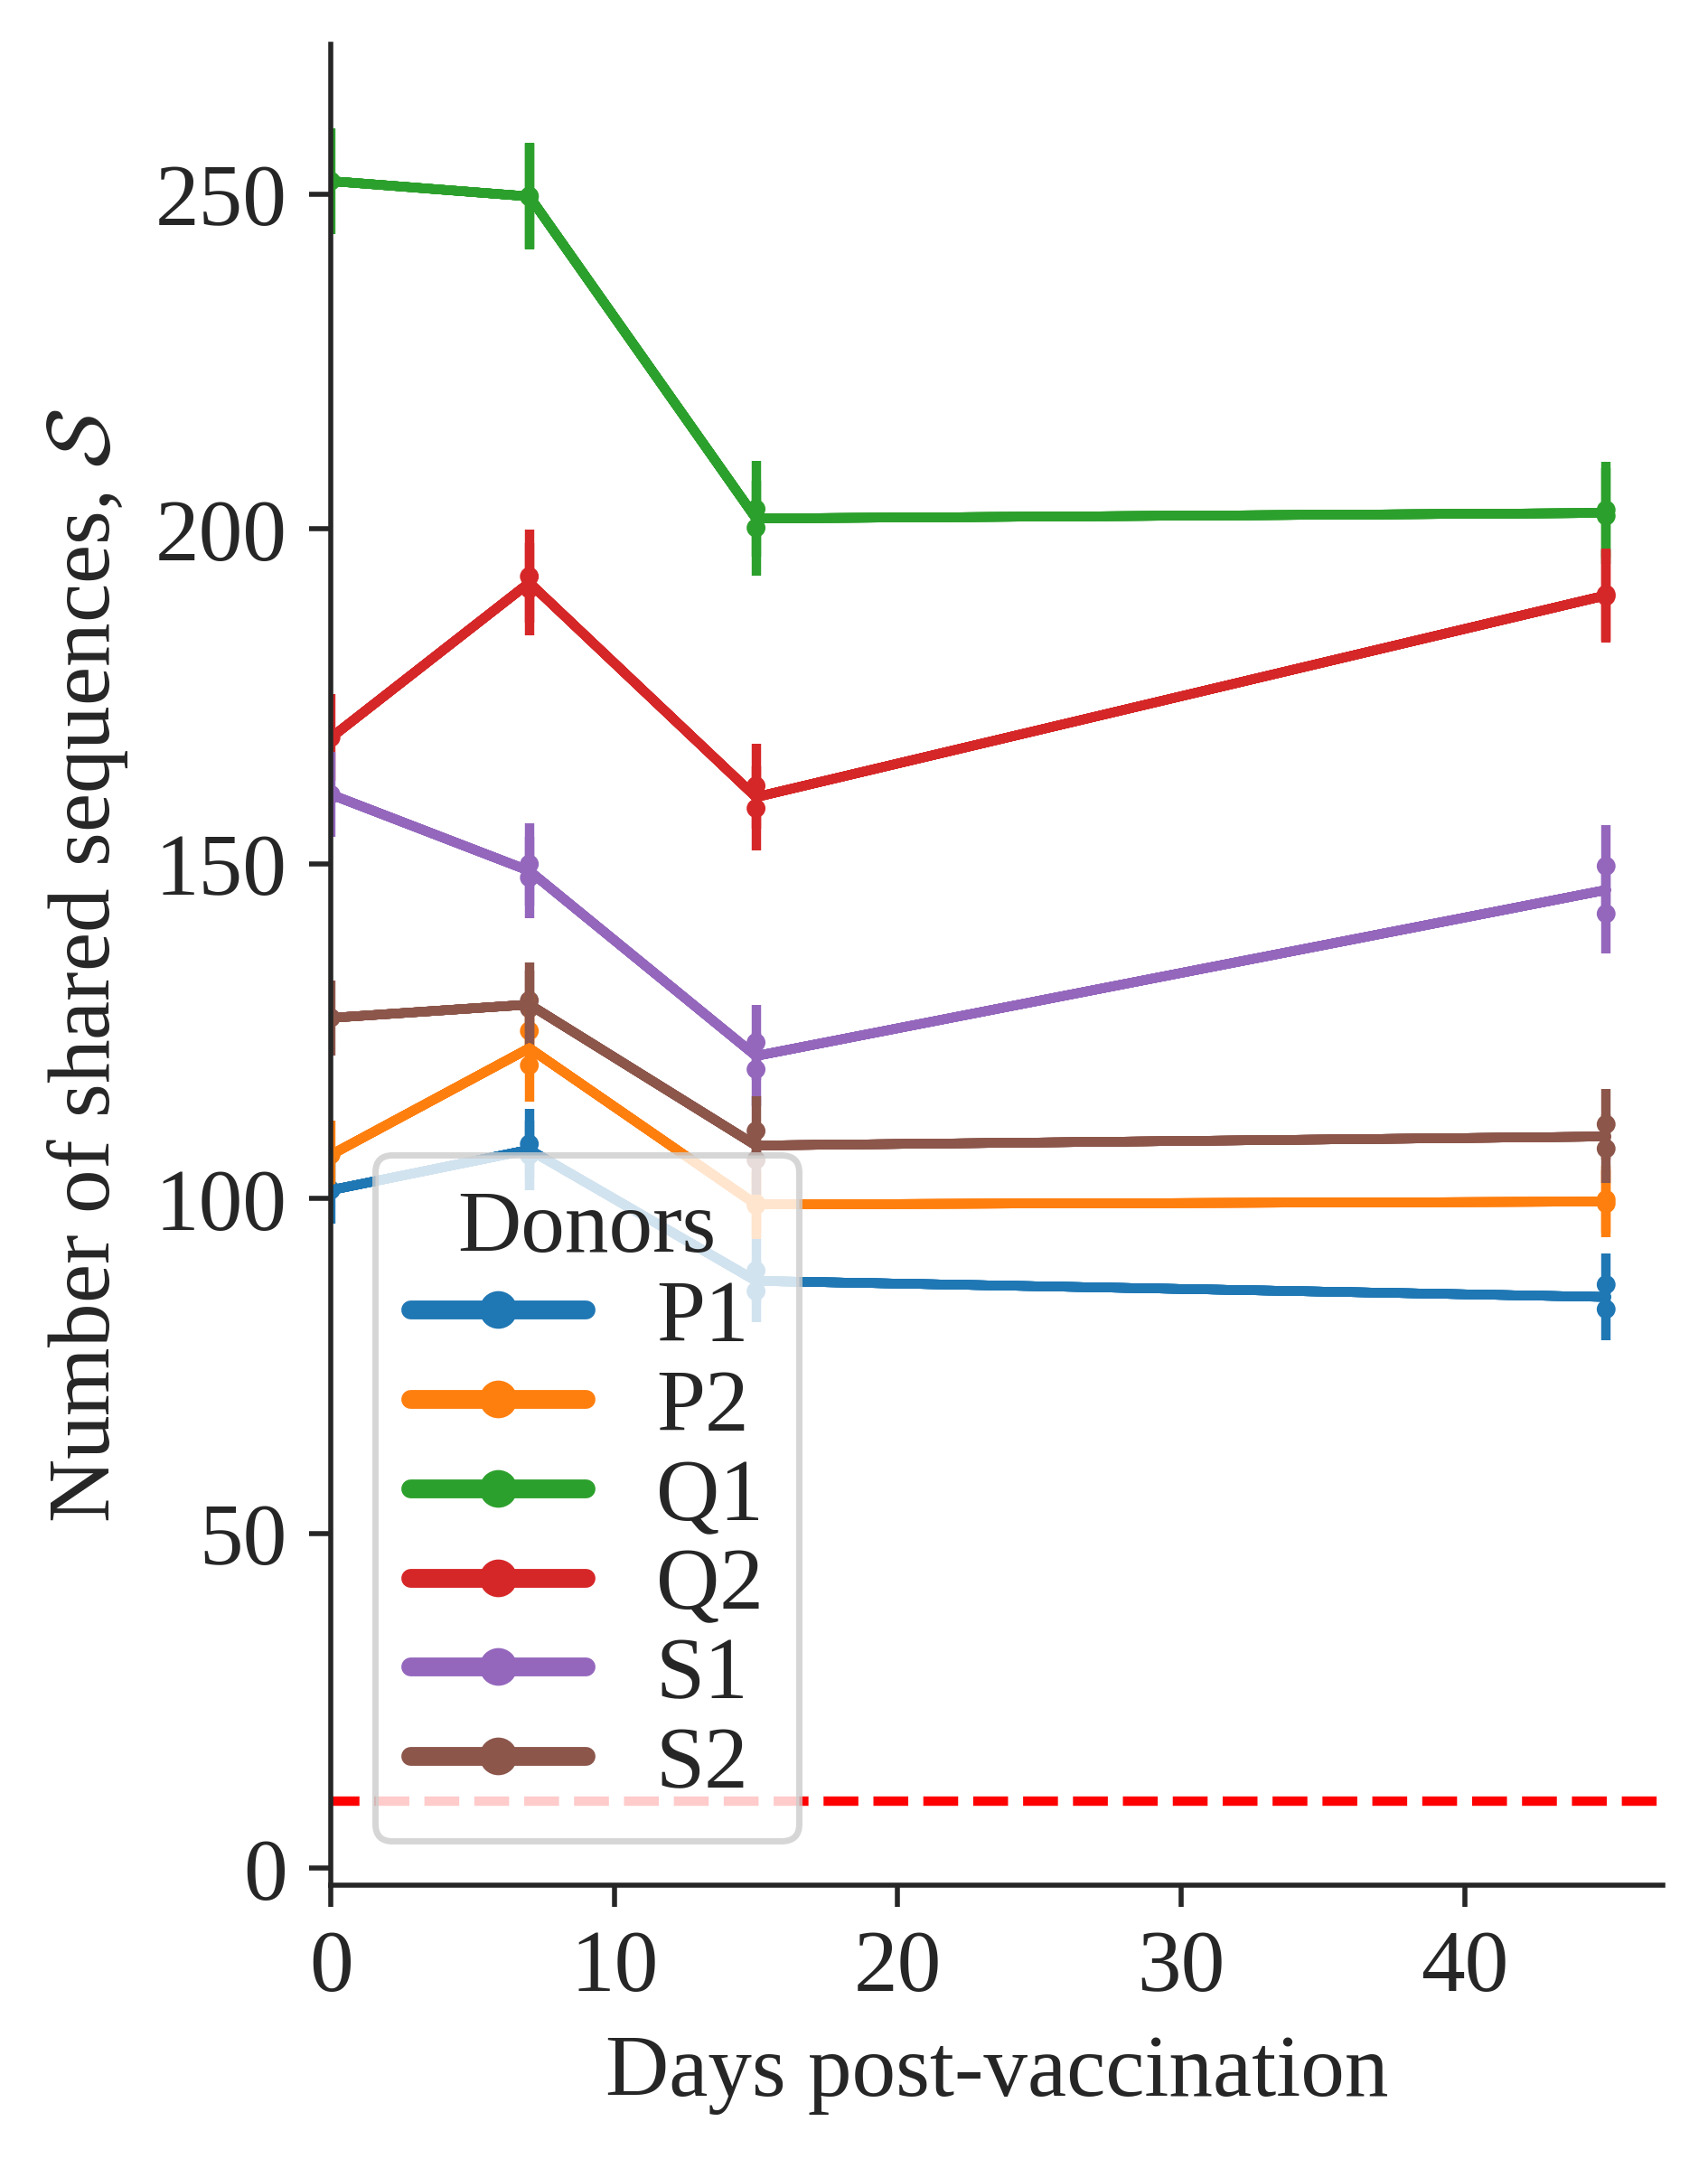

In [63]:


patients = ["P1", "P2", "Q1", "Q2", "S1", "S2"]
sharemin = 10
col_patients, col_time, col_rep, col_s, col_s0 = [], [], [], [], []
for p in patients:
    for t in ["0", "7", "15", "45"]:
        for i in ["1", "2"]:
            if (t, i) != ("0", "1"):
                col_patients.append(p)
                col_time.append(int(t))
                col_rep.append(i)
                if p + "10" < p + i + t:
                    col_s.append(Smean[ (p, "0", "1"), (p, t, i)])
                else:
                    col_s.append(Smean[(p, t, i), (p, "pre0", "1")])
                col_s0.append(Smean[ (p, "0", "1"), (p, "0", "2")])

df = pd.DataFrame({"patient": col_patients, "time": col_time, 
              "replicate": col_rep, "meanS": col_s, "meanS0": col_s0})

dct_patient = {a: ii for ii, a in enumerate(df.patient.unique())}
print(dct_patient)
df["color"] = df.patient.apply(lambda x: sns.color_palette()[dct_patient[x]])
dct_time = {a: ii for ii, a in enumerate(df.time.unique())}
fig, ax = plt.subplots(figsize=(4, 5))
ax.scatter(df.time, df.meanS, c=df.color, s=4)
for p in df.patient.values:
    dfp = df[df.patient == p].groupby("time").meanS.mean().to_frame().reset_index()
    ax.plot(dfp.time, dfp.meanS, c=sns.color_palette()[dct_patient[p]])
ax.errorbar(x=df.time, y=df.meanS, yerr=np.sqrt(df.meanS)/2, linestyle='', c=df.color)


ax.plot([-2, 50], [sharemin, sharemin], color="r", ls='--')
ax.set_xlim(0, 47)

lines = [Line2D([0], [0], color=sns.color_palette()[dct_patient[ii]] ,
                linewidth=3, linestyle='-', marker='.', markersize=10) for ii in dct_patient]
labels = [f'{p}' for p in dct_patient.keys()]
leg = Legend(ax, lines, labels,title="Donors", loc="lower left", labelspacing=0.1)#, bbox_to_anchor=(1, 1))
ax.add_artist(leg)

xmin, xmax = ax.get_xlim() 
ymin, ymax = ax.get_ylim()
 
# removing the default axis on all sides:
for side in ['right','top']:
    ax.spines[side].set_visible(False)

ax.set_xlabel("Days post-vaccination")
ax.set_ylabel("Number of shared sequences, $\mathcal{S}$")
plt.tight_layout()
plt.savefig("fig3a.pdf")
plt.show()

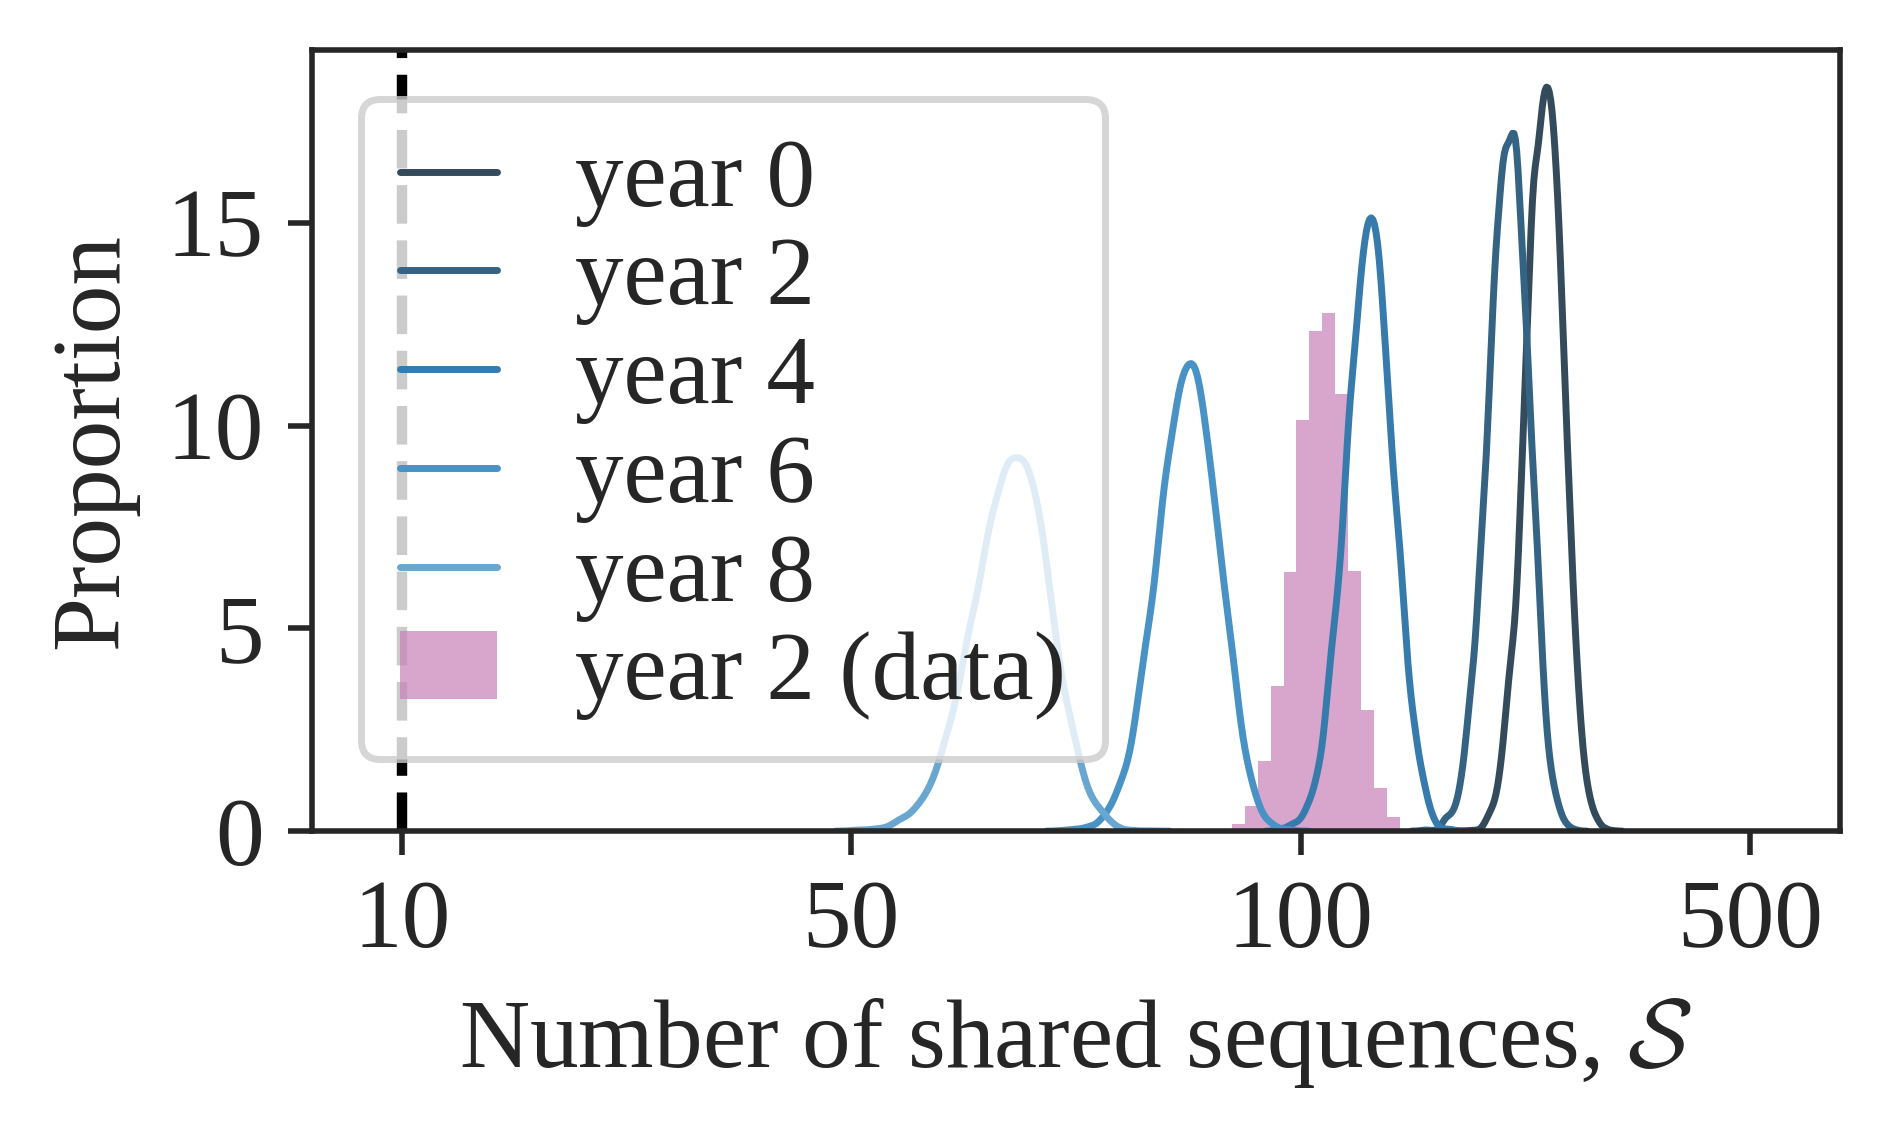

In [66]:
dfdata = pd.read_excel("../datasets/I_S_S1_2years.xlsx")
dfth = pd.read_excel("../datasets/I_S1_tau_1_B_2.xlsx")
fig, ax = plt.subplots(figsize=(4, 2.5))
for ii in range(0, 10, 2):
    sns.distplot(np.log10(dfth[f"year_{ii}_S"]), ax=ax,
                 label=f"year {ii}", kde=True, hist=False,
                 color=sns.color_palette("Blues_d")[ii//2],
                 kde_kws={'linewidth':1})

ax.hist(np.log10(dfdata["data_year_2_S"]), density=True, bins=15,
        color="#C880B7",  #"xkcd:dark lavender",
        label="year 2 (data)", alpha=0.7,
        #histtype="stepfilled", 
        linewidth=0)

# ax.plot([], [], label="year 2 (data)", 
#            color='xkcd:dark lavender', linewidth=2)
# 
ax.axvline(np.log10(10), linestyle="--", color='k')
ax.set_xlabel("Number of shared sequences, $\mathcal{S}$")
ax.set_ylabel("Proportion")
ax.set_xticks([a for a in np.arange(1, 3, 0.5)])
ax.set_xticklabels(["10", "50", "100", "500"])
ax.set_xlim(0.9, 2.6)

params = {'legend.handlelength': 1}
plt.rcParams.update(params)
ax.legend(labelspacing=0.1)
plt.tight_layout()
plt.savefig("fig3b.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()


## Fig 3C

In [95]:
import pickle
from datetime import datetime
with open("../datasets/RobinsLongTcells_SI.pkl", "rb") as f:
    dct = pickle.load(f)  
    
RobinsLTC = {"S": {}, "I": {}}
for a, b in dct[0]:
    t1, t2 = a[10:-5], b[10:-5]
    t1 = datetime.strptime(t1, '%y%m%d')
    t2 = datetime.strptime(t2, '%y%m%d')
    dt = t2 - t1
    RobinsLTC["S"][dt.days, a, b] = dct[0][a, b]



In [96]:
with open("../datasets/YF_SI_all.pkl", "rb") as f:
    Smeans_YF, Imeans_YF = pickle.load(f)

In [97]:
two_years_res = {}
two_years_res["S"] = [
Smeans_YF[(('S1', '0', '1'), ('S1', '730', '1'))]/Smeans_YF[(('S1', '0', '1'), ('S1', '7', '1'))],
Smeans_YF[(('S1', '0', '1'), ('S1', '730', '2'))]/Smeans_YF[(('S1', '0', '1'), ('S1', '7', '1'))],
Smeans_YF[(('S2', '0', '1'), ('S2', '730', '1'))]/Smeans_YF[(('S2', '0', '1'), ('S2', '7', '1'))],
Smeans_YF[(('S2', '0', '1'), ('S2', '730', '2'))]/Smeans_YF[(('S2', '0', '1'), ('S2', '7', '1'))]
]

In [98]:
def generate_BM(x0, fmin, t, τ, θ=None):
    
    """
    Generate Brownian Motion trajectories in the log-frequencies space for every clone in df (line in df) using 
    Euler-Mayurama method
    Input : 
    df : data-frame
    τ, θ : respectively drift and diffusion coefficients, B < 2|A|, 2|A] = B + epsilon (study to be confirmed in 
    my paper youhou) 
    t : timescale, chose wisely the dt! for accurate simulations : dt << 1/A, 1/B
    
    """
    if θ is None:
        θ = τ/2
    dt = np.diff(t)[0]
    u = - 1/τ*(dt) + np.sqrt(1/θ*dt)*np.random.randn(len(t), len(x0))
    x = x0[None, :] + np.cumsum(u, axis=0)
    v = np.zeros((len(t), len(x0)))
    v[x < np.log(fmin)] = -np.inf
    v = np.cumsum(v, axis=0)
    x = x + v
    return x

def power_law(k_min, k_max, y, gamma):
    return ((k_max**(-gamma+1) - k_min**(-gamma+1))*y  + k_min**(-gamma+1.0))**(1.0/(-gamma + 1.0))

df = pd.read_csv('S1_45_F1_pgen.tsv.gz', sep='\t')
df = df.groupby('ntCDR3').agg(count=('count', 'sum'), 
                              pgen_nt=('pgen_nt','first')
                             ).reset_index()
df["frequency"] = df["count"]/df["count"].sum()

S = {}
ts = np.linspace(0, 10, 1000)
for τ in [0.5, 1, 4, 10]:
    # θ = 1/4
    fmin = 1e-11 
    M = 10000
    f0 = np.random.choice(df.frequency, p=df.frequency, size=M, replace=True)  # select M cells
    x = generate_BM(np.log(f0), fmin, ts, τ)
    f = np.exp(x)
    
    S[τ] = np.sum((1 - np.exp(-f*M)), axis=1)#*(1 - np.exp(-f0*M)), axis=1)

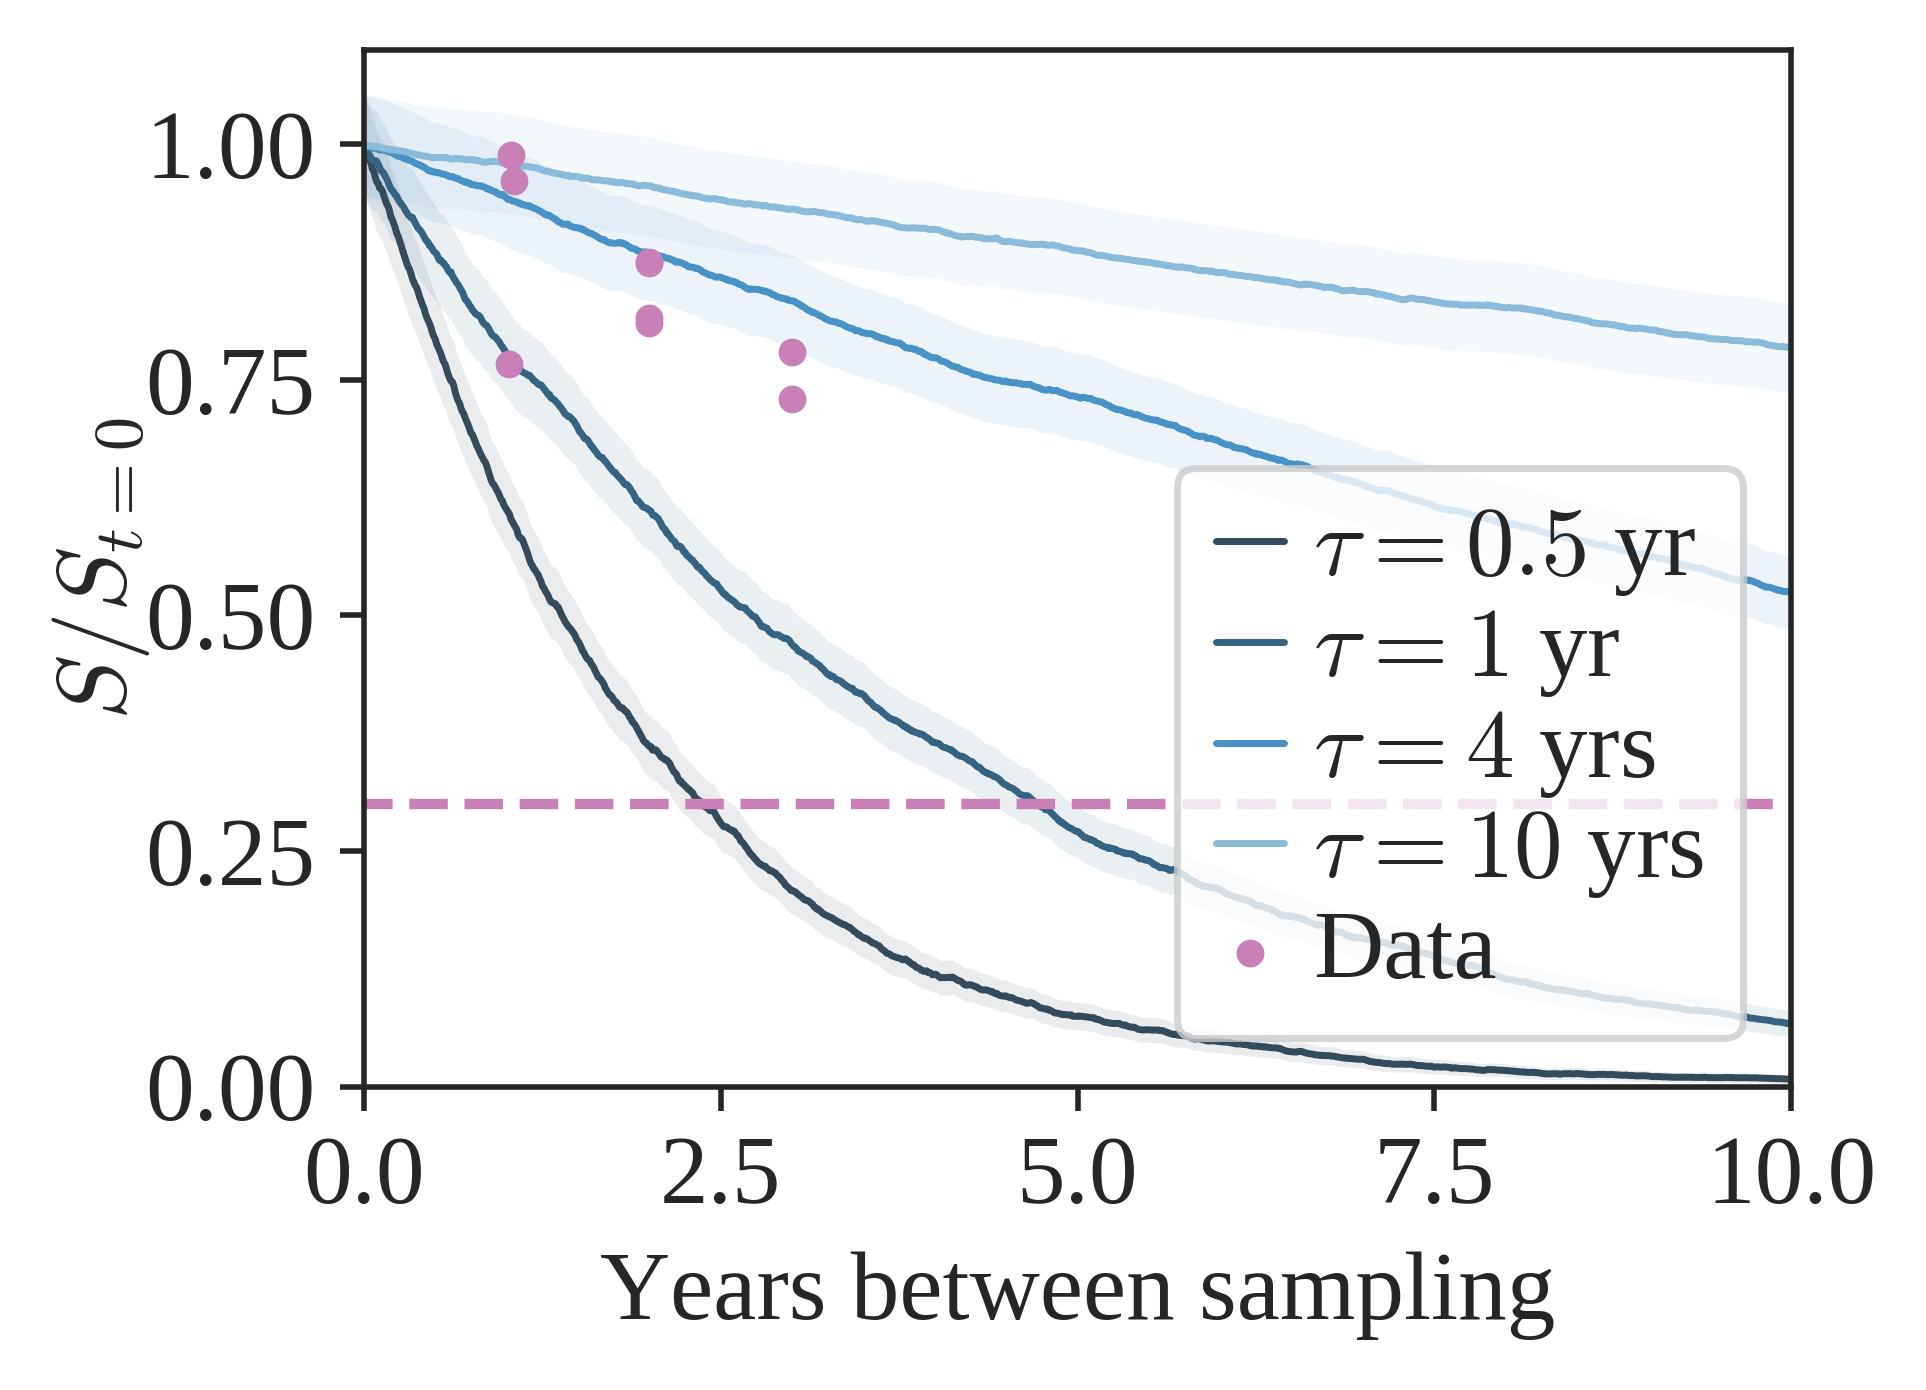

In [99]:
tp = "S"
fig, ax = plt.subplots(figsize=(4, 3))
  
dct_color = {}
dct_color[0.5] = sns.color_palette("Blues_d")[0]
dct_color[1] = sns.color_palette("Blues_d")[1]
dct_color[4] = sns.color_palette("Blues_d")[3]
dct_color[10] = sns.color_palette("Blues_d")[5]


for τ in [0.5, 1, 4, 10]: 
    x=ts[::1]
    y=S[τ][::1]/S[τ][0]
    yerr= 2 * np.sqrt(S[τ][::1])/S[τ][0]
    ax.plot(x, y, color=dct_color[τ], linewidth=1., label=f"$\\tau = {τ}$ yr" + ("s" if τ > 1 else ""))
    ax.fill_between(x, y - yerr, y + yerr, color=dct_color[τ], alpha=0.1, lw=0)



data_color = "#C880B7"
tr = 0.3
ax.plot([-2, 12], [tr, tr], '--', color=data_color)
for subj in ["Subject01", "Subject02", "Subject03"]:
    dm = max([d for d, a, b in RobinsLTC[tp] if subj in a])
    a, b = [(a, b) for d, a, b in RobinsLTC[tp] if subj in a if d == dm][0]
    ax.scatter([dm/365], 
               [RobinsLTC['S'][dm, a, b]/st.mstats.gmean([RobinsLTC['S'][x, a, b] for x,a,b in RobinsLTC[tp] if 0 < x < 35 and subj in a])], 
               color=data_color,#"xkcd:dark lavender", 
               marker='.', zorder=10)

ax.scatter([730/365]*4, two_years_res[tp], color=data_color, marker='.', label="Data", zorder=10)

ax.scatter([3, 3], [0.78, 0.73], color=data_color,
           marker='.', zorder=10) # values given by Meriem, but that's kind of ugly

ax.set_xlim((0, 10))
ax.set_ylim((0, 1.1))
ax.set_xlabel("Years between sampling")
ax.set_ylabel(f"$S/S_{{t=0}}$", labelpad=-1)
ax.legend(labelspacing=0.1, handlelength=0.7, handletextpad=0.3, loc="lower right")

plt.tight_layout()


plt.savefig("fig3c.pdf", bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Figures SI

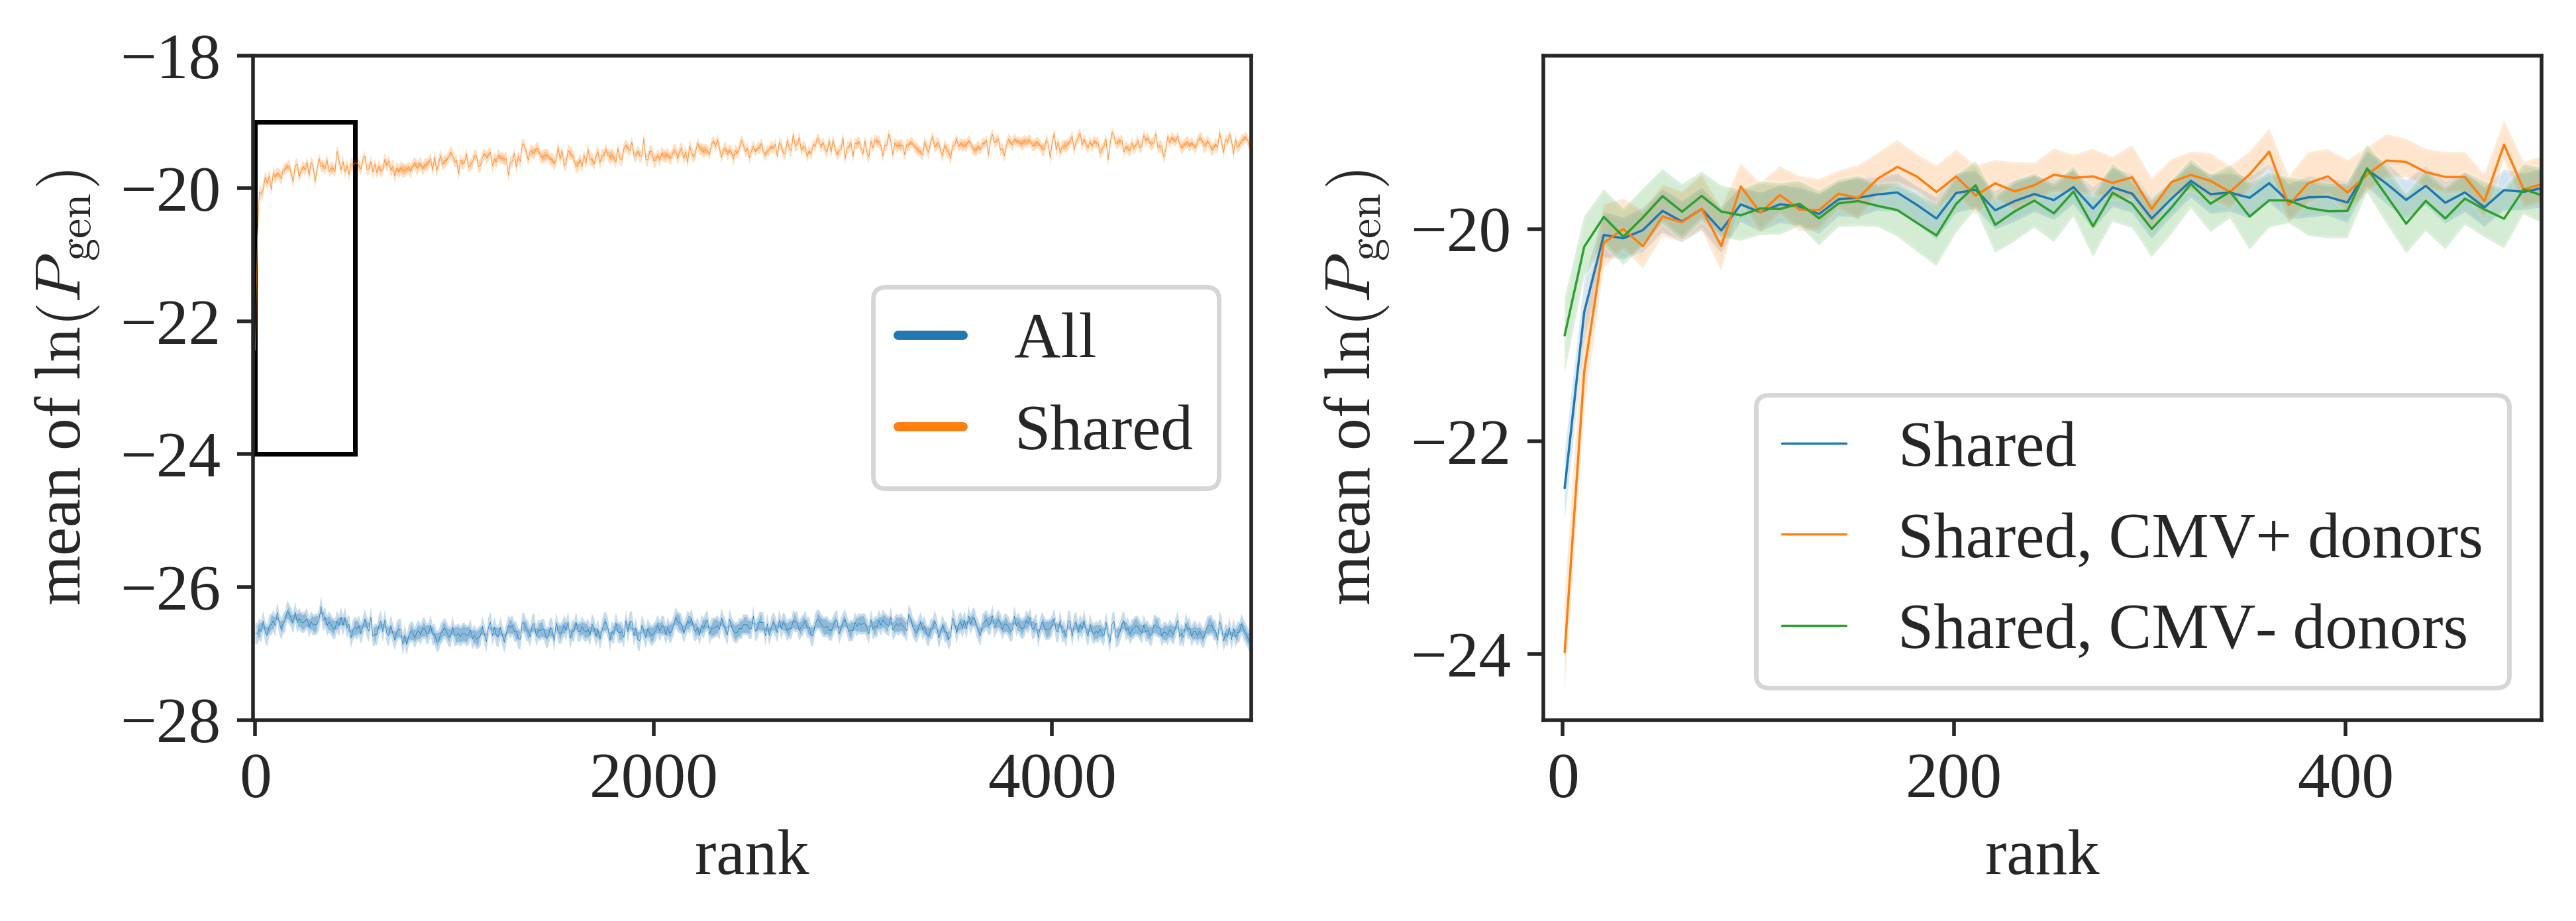

In [30]:
# Pgen is stable among top-clones (shared or not) ?
df_descr = pd.read_csv("../datasets/Emerson_Robins_cohort_1.tsv.gz", sep="\t")
df_descr["CMV_status"] = df_descr.sample_tags.apply(
    lambda x: "Negative" if "Cytomegalovirus -" in x 
    else "Positive" if "Cytomegalovirus +" in x else "Unknown")

dfs = pd.read_csv("../datasets/top_clones_pgen.csv.gz")

pos_cmv = df_descr[df_descr.CMV_status == "Positive"].sample_name.values
neg_cmv = df_descr[df_descr.CMV_status == "Negative"].sample_name.values

dfg = dfs.groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()
dfg_shared = dfs[dfs.nb_indiv_found >= 2].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()
dfg_shared_cmv = dfs[(dfs.sample_name.isin(pos_cmv)) 
                     & (dfs.nb_indiv_found >= 2)].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()
dfg_shared_noncmv = dfs[(dfs.sample_name.isin(neg_cmv)) & 
                        (dfs.nb_indiv_found >= 2)].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()

dfg_found2 = dfs[dfs.nb_indiv_found == 2].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(dfg.rank10, dfg.logpgen["mean"], lw=0.1, label="All")
ax1.plot(dfg_shared.rank10, dfg_shared.logpgen["mean"], lw=0.1, label="Shared")
ax1.fill_between(dfg.rank10, dfg.logpgen["mean"]+2*dfg.logpgen["std"]/np.sqrt(dfg.nt["nunique"]),
                dfg.logpgen["mean"]-2*dfg.logpgen["std"]/np.sqrt(dfg.nt["nunique"]),
                facecolor=sns.color_palette()[0], alpha=0.5)
ax1.fill_between(dfg_shared.rank10, dfg_shared.logpgen["mean"]+dfg_shared.logpgen["std"]/np.sqrt(dfg_shared.nt["nunique"]),
                dfg_shared.logpgen["mean"]-dfg_shared.logpgen["std"]/np.sqrt(dfg_shared.nt["nunique"]),
                facecolor=sns.color_palette()[1], alpha=0.5)
ax1.set_xlim(-10, 5000)
ax1.set_ylim(-28, -18)

# Create a Rectangle patch
xy, (w, h) = ax1.transData.transform([(0, -24), (500, 5)])

rect = mpl.patches.Rectangle((0, -24), 500, 5,linewidth=1,edgecolor='k',
                             facecolor='none', transform=ax1.transData)

# Add the patch to the Axes
ax1.add_patch(rect)

leg = ax1.legend()

for line in leg.get_lines():
    line.set_linewidth(2.0)

ax1.set_xlabel("rank")
ax1.set_ylabel(r"mean of $\ln\left(P_\mathrm{gen}\right)$")



dfg = dfs.groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()
dfg_shared = dfs[dfs.nb_indiv_found >= 2].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()
dfg_found2 = dfs[dfs.nb_indiv_found == 2].groupby("rank10").agg({"logpgen": ["mean", "std"], "nt": "nunique"}).reset_index()

ax2.plot(dfg_shared.rank10, dfg_shared.logpgen["mean"], lw=0.5, label="Shared")
ax2.plot(dfg_shared_cmv.rank10, dfg_shared_cmv.logpgen["mean"], lw=0.5, label="Shared, CMV+ donors")
ax2.plot(dfg_shared_noncmv.rank10, dfg_shared_noncmv.logpgen["mean"], lw=0.5, label="Shared, CMV- donors")
# ax.fill_between(dfg.rank10, -dfg.logpgen["mean"]+2*dfg.logpgen["std"]/np.sqrt(dfg.nt["nunique"]),
#                 -dfg.logpgen["mean"]-2*dfg.logpgen["std"]/np.sqrt(dfg.nt["nunique"]),
#                 facecolor=sns.color_palette()[0], alpha=0.5)
ax2.fill_between(dfg_shared.rank10, dfg_shared.logpgen["mean"]
                -2*dfg_shared.logpgen["std"]/np.sqrt(dfg_shared.nt["nunique"]),
                dfg_shared.logpgen["mean"]
                +2*dfg_shared.logpgen["std"]/np.sqrt(dfg_shared.nt["nunique"]),
                facecolor=sns.color_palette()[0], alpha=0.2)
ax2.fill_between(dfg_shared_cmv.rank10, 
                dfg_shared_cmv.logpgen["mean"]
                -2*dfg_shared_cmv.logpgen["std"]/np.sqrt(dfg_shared.nt["nunique"]),
                dfg_shared_cmv.logpgen["mean"]
                +2*dfg_shared_cmv.logpgen["std"]/np.sqrt(dfg_shared_cmv.nt["nunique"]),
                facecolor=sns.color_palette()[1], alpha=0.2)
ax2.fill_between(dfg_shared_noncmv.rank10, 
                dfg_shared_noncmv.logpgen["mean"]
                -2*dfg_shared_noncmv.logpgen["std"]/np.sqrt(dfg_shared_noncmv.nt["nunique"]),
                dfg_shared_noncmv.logpgen["mean"]
                +2*dfg_shared_noncmv.logpgen["std"]/np.sqrt(dfg_shared_noncmv.nt["nunique"]),
                facecolor=sns.color_palette()[2], alpha=0.2)
ax2.set_xlim(-10, 500)
ax2.legend()
ax2.set_xlabel("rank")
ax2.set_ylabel(r"mean of $\ln\left(P_\mathrm{gen}\right)$")
plt.tight_layout()
## list of all possible samples of the Emerson dataset
def list_Emerson_samples():
    lst = !ssh piast 'ls /var/services/homes/SHARED/Emerson_Robins_TRB_666+120/Mixcr/'
    return [a[:-13] for a in lst]

fig.savefig("figSI_rank_vs_pgen.pdf", handletextpad=0.1)

In [265]:
with open("../datasets/all_means_Emerson_S_I_Ms.pkl", "rb") as file:
    result = pickle.load(file)
    
meanEmersonS = {}
meanEmersonI = {}
for M in Ms:
    meanEmersonS[M] = {}
    meanEmersonI[M] = {}
for s, (S, I) in zip(list(list_Emerson_samples()), result):
    for M in Ms:
        meanEmersonS[M][s] = S[M]
        meanEmersonI[M][s] = I[M]

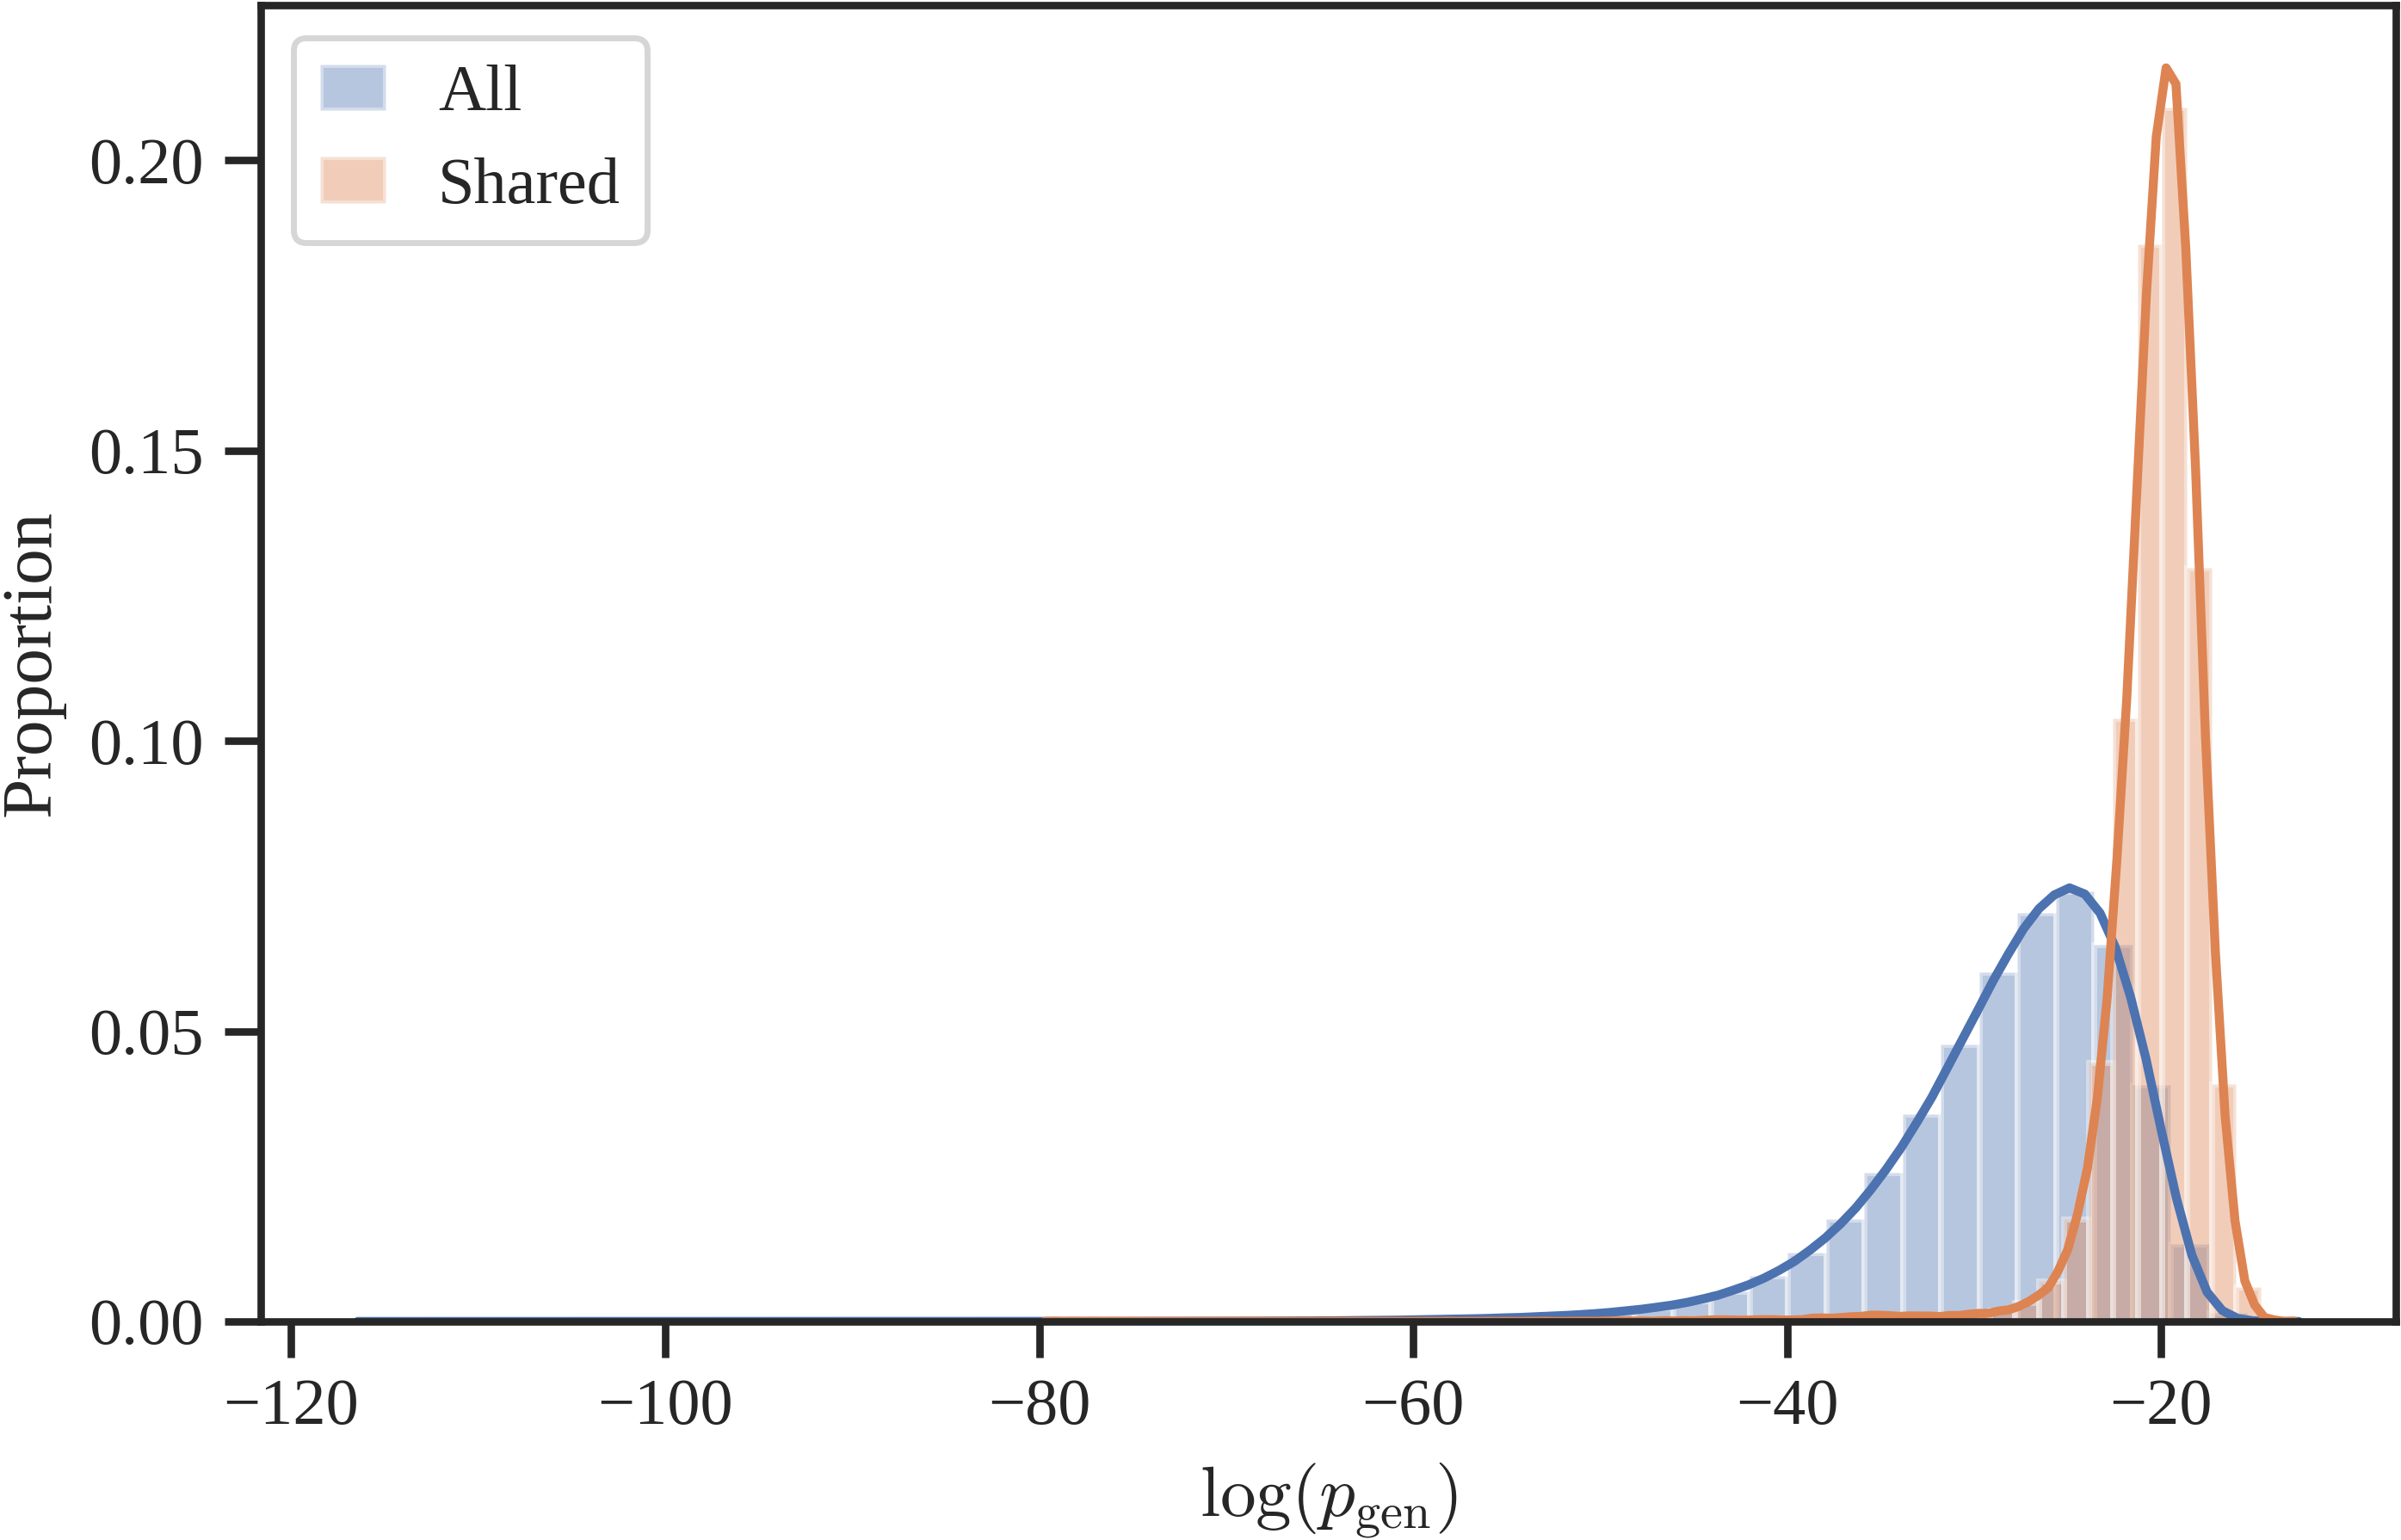

In [492]:
dfpg = dfs.groupby('nt').logpgen.first()
dfpg2 = dfs[dfs.nb_indiv_found >= 2].groupby('nt').logpgen.first()
sns.distplot(dfpg, label="All")
sns.distplot(dfpg2, label="Shared")
plt.xlabel("$\log(p_\mathrm{gen})$")
plt.ylabel("Proportion")
plt.legend()
plt.tight_layout()
plt.savefig("SI_pgen_distribution.pdf")
plt.show()

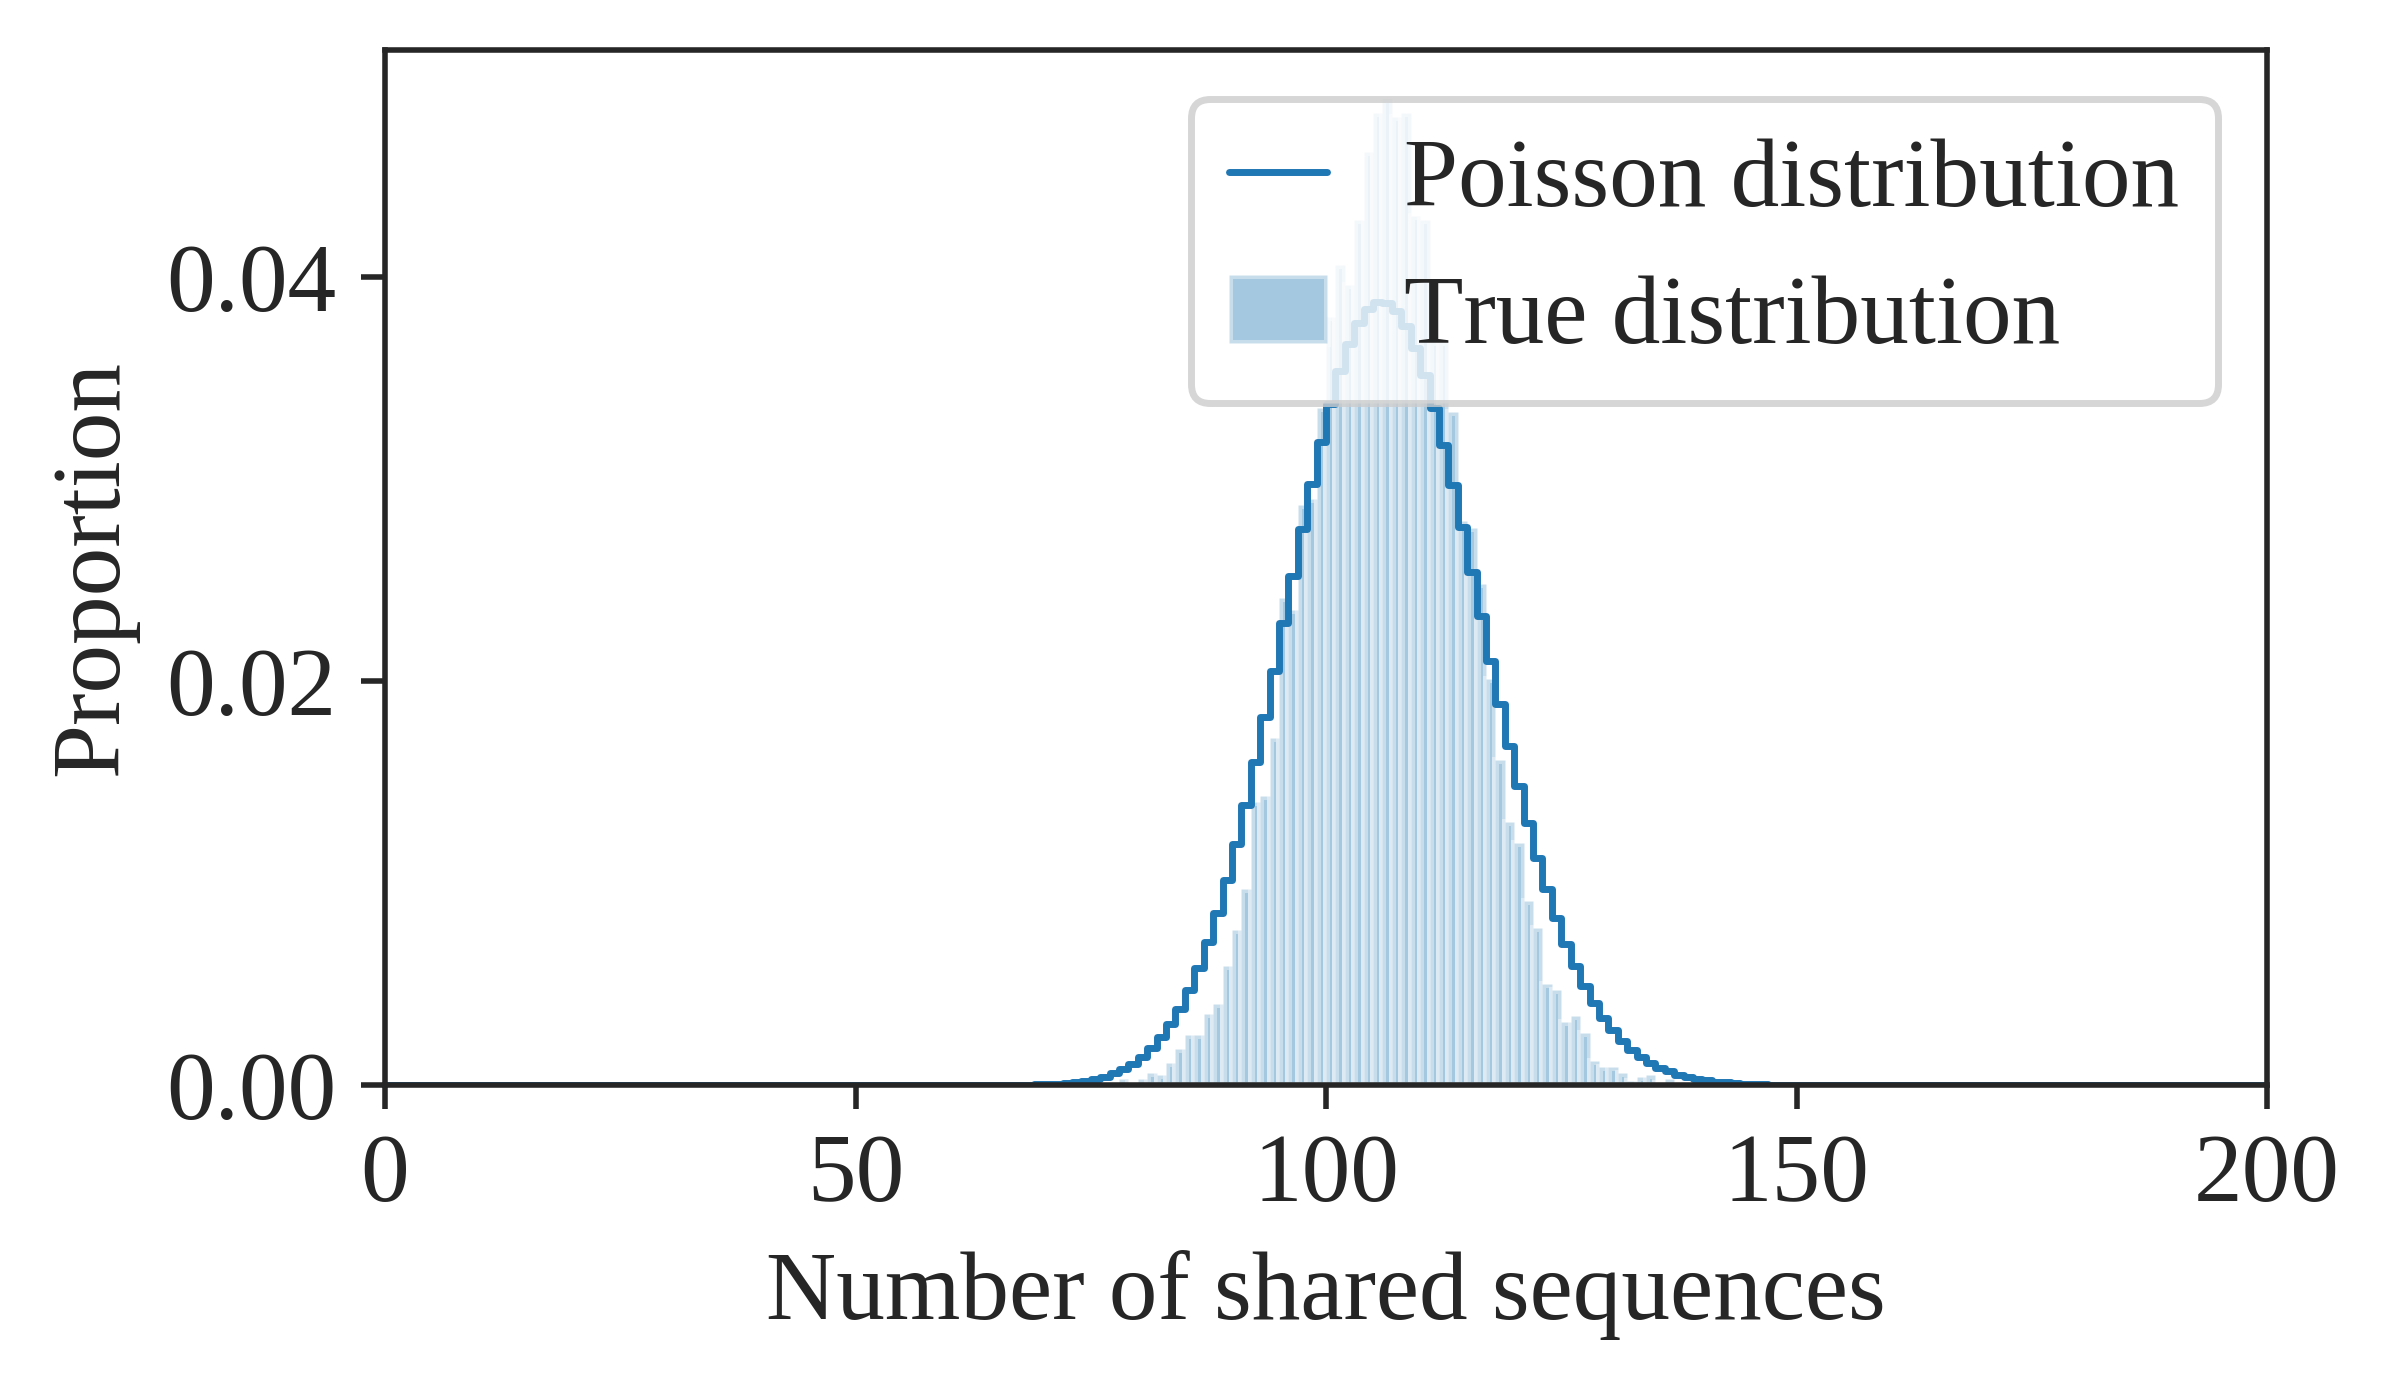

In [81]:
# Poisson versus poisson binomial, for S
# Fig 2C
def plot_poisson(m, ax, color="k", label=None):
    rg = np.arange(0, int(40*m))
    ax.plot(rg, [scipy.stats.poisson.pmf(k, m) for k in rg], 
            color=color, drawstyle='steps-post', label=label,
            linewidth=1)

dft = pd.read_csv("YFV_SI_data.csv.gz")
dft["patient"] = dft.patient.apply(eval)
dft["patients"] = dft.patient.apply(lambda x: x[0] + "-" + x[1])
dft["distS"] = dft.distS.apply(eval)
dft = dft.set_index("patients")
dft = dft.loc[["P1-P1", "P2-P2", "Q1-Q1", "Q2-Q2",
               "S1-S1", "S2-S2", "P1-Q1", "P1-S1",
               "Q1-S1", "P1-P2", "Q1-Q2", "S1-S2"]]


fig, ax2 = plt.subplots(1,1, facecolor='w', figsize=(5, 3))
ii1 = ii2 = 0
for ii, line in dft.iterrows():
    if ii in ["P1-P1"]:#, "S1-S1", "S2-S2"]:# line.patient[0] == line.patient[1]:
        sns.distplot(line.distS, ax=ax2, bins=range(50, 300), 
                     kde=False, norm_hist=True,
                     color=sns.color_palette()[ii1%10],
                     label="True distribution")
        plot_poisson(np.mean(line.distS), ax2, color=sns.color_palette()[ii1], label="Poisson distribution")
        ii1 += 1
ax2.set_xlim((0, 200))
ax2.legend()
ax2.set_xlabel("Number of shared sequences")
ax2.set_ylabel("Proportion")
plt.tight_layout()
plt.savefig("SI_Fig_Poisson_vs_Poisson_binomial.pdf")

In [82]:
γ = -12
# mean of S if the 2 samples are autologous (scenario 1)
meanS1 = lambda M: 19.9/(5000**2) * M**2

# mean of S if the 2 samples are *not* autologous (scenario 2)
meanS2 = lambda M: meanS * M**2 #0.35/(1000**2) 

mpmath.mp.dps = 50 # increase precision

Q = 1_000_000
Ms = [5, 10, 20, 30, 50, 70, 100]
eqMs = [np.sqrt(Q*m) for m in Ms]

tprS = defaultdict(list)
fprS = defaultdict(list)
fnrS = defaultdict(list)

for M, eM in tqdm(zip(Ms, eqMs)): # for different sample size
    for r in range(0, M): # for various thresholds r
        false_negative = regularized_gamma_Q(r+1, meanS1(eM))
        true_negative = regularized_gamma_Q(r+1, meanS2(eM))
        false_positive = 1 - regularized_gamma_Q(r+1, meanS2(eM))
        true_positive = 1 - regularized_gamma_Q(r+1, meanS1(eM))

        tprS[M].append(true_positive/(false_negative + true_positive))
        fnrS[M].append(1 - true_positive/(false_negative + true_positive))
        fprS[M].append(false_positive/(true_negative + false_positive))


tprI = defaultdict(list)
fprI = defaultdict(list)
fnrI = defaultdict(list)

for M, eM in tqdm(zip(Ms, eqMs)): # for different sample size
    for r in np.arange(1, M*30): # for various thresholds r
        
        # all already "normalized"
        false_negative = boundI1(r, eM, µp=µp + γ, maxM=M)
        true_negative = 1 - boundI2(r, eM, µp=µp2 + γ, maxM=M)
        false_positive = boundI2(r, eM, µp=µp2+ γ, maxM=M)
        true_positive = 1 - boundI1(r, eM, µp=µp + γ, maxM=M)
        tprI[M].append(true_positive)
        fnrI[M].append(false_negative)
        fprI[M].append(false_positive)
        if false_positive < 1e-30:
            break

<ipython-input-83-3c9e2dbd59fe>:14: RuntimeWarning: divide by zero encountered in log10
  ax.plot([np.log10(float(x)) for x in fprI[M]],


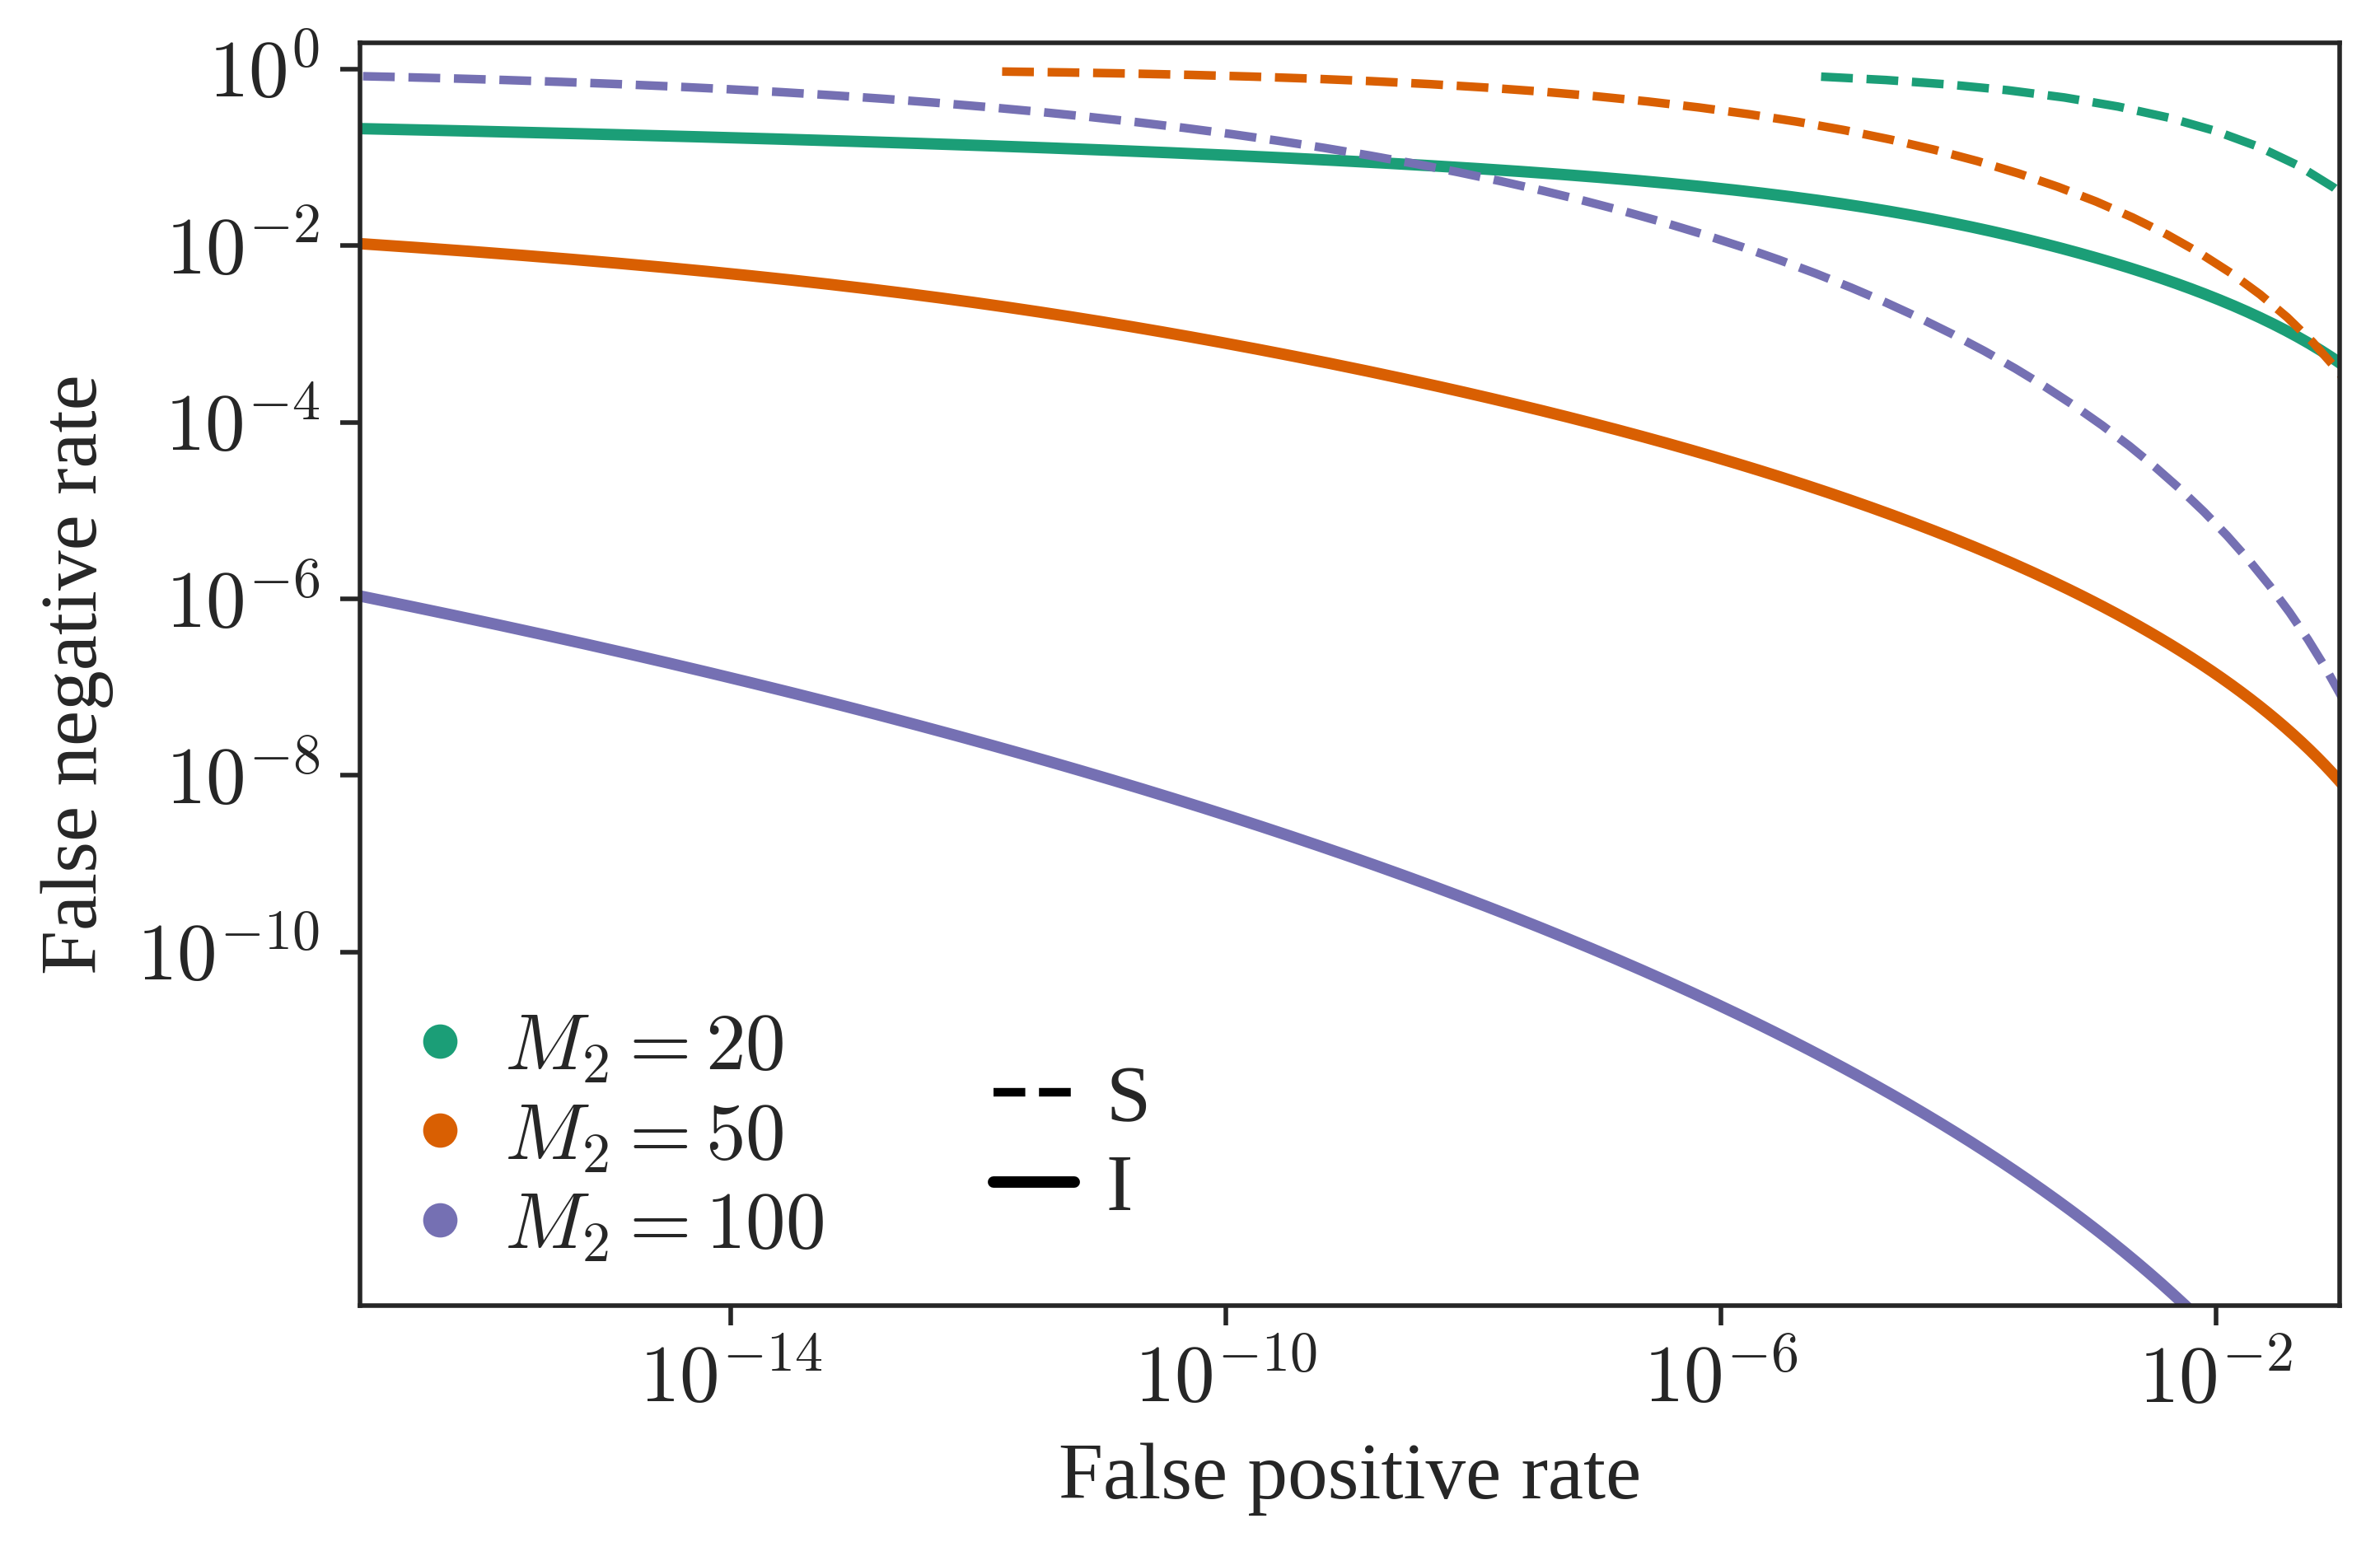

In [83]:
Ms = [20, 50, 100]
lw = 2
alpha = 1.
flatui = ['#1b9e77','#d95f02','#7570b3']
pal = sns.color_palette(flatui)

fig, ax = plt.subplots(figsize=(6, 4))


linesS, linesI = [], []
for ii, M in enumerate(Ms):
    fprI[M], fnrI[M] = zip(*sorted(zip(fprI[M], fnrI[M])))
    fprS[M], fnrS[M] = zip(*sorted(zip(fprS[M], fnrS[M])))
    ax.plot([np.log10(float(x)) for x in fprI[M]], 
            [np.log10(float(x)) for x in fnrI[M]], 
            color=pal[ii], linewidth=lw, alpha=alpha)

    ax.plot([np.log10(float(x)) for x in fprS[M]],
            [np.log10(float(x)) for x in fnrS[M]],
                        '--', ms=3, 
            color=pal[ii], alpha=alpha, label=f"{M}")
    

ax.set_yticks([a for a in range(-10, 1, 2)])
ax.set_yticklabels([f"$10^{{{a}}}$" for a in range(-10, 1, 2)])
ax.set_xticks([a for a in range(-26, 1, 4)])
ax.set_xticklabels([f"$10^{{{a}}}$" for a in range(-26, 1,  4)])

ax.set_ylim(-14, 0.3)
ax.set_xlim(-17, -1)

ax.set_xlabel("False positive rate")
ax.set_ylabel("False negative rate")

lines2 = [Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linewidth=lw)]
labels2 = ["S", "I"]
leg = Legend(ax, lines2, labels2, frameon=False, loc='lower left',
             bbox_to_anchor=(0.3, 0.03, 0.5, 0.5),
            handlelength=1,
          handletextpad=0.4, labelspacing=0.2, borderpad=0.)
ax.add_artist(leg)

lines1 = [Line2D([0], [0], color=pal[ii], linestyle='', marker='.', ms=10) for ii, _ in enumerate(Ms) ]
labels1 = [f"$M_2 = {M}$" for M in Ms]
leg = Legend(ax, lines1, labels1, frameon=False, loc='lower left',
             bbox_to_anchor=(0., 0, 0.5, 0.5),
            handlelength=1,
          handletextpad=0.3, labelspacing=0.2, borderpad=0.)
ax.add_artist(leg)

plt.tight_layout()
plt.savefig("SI_full_dataset_vs_small_sample.pdf")
plt.show()


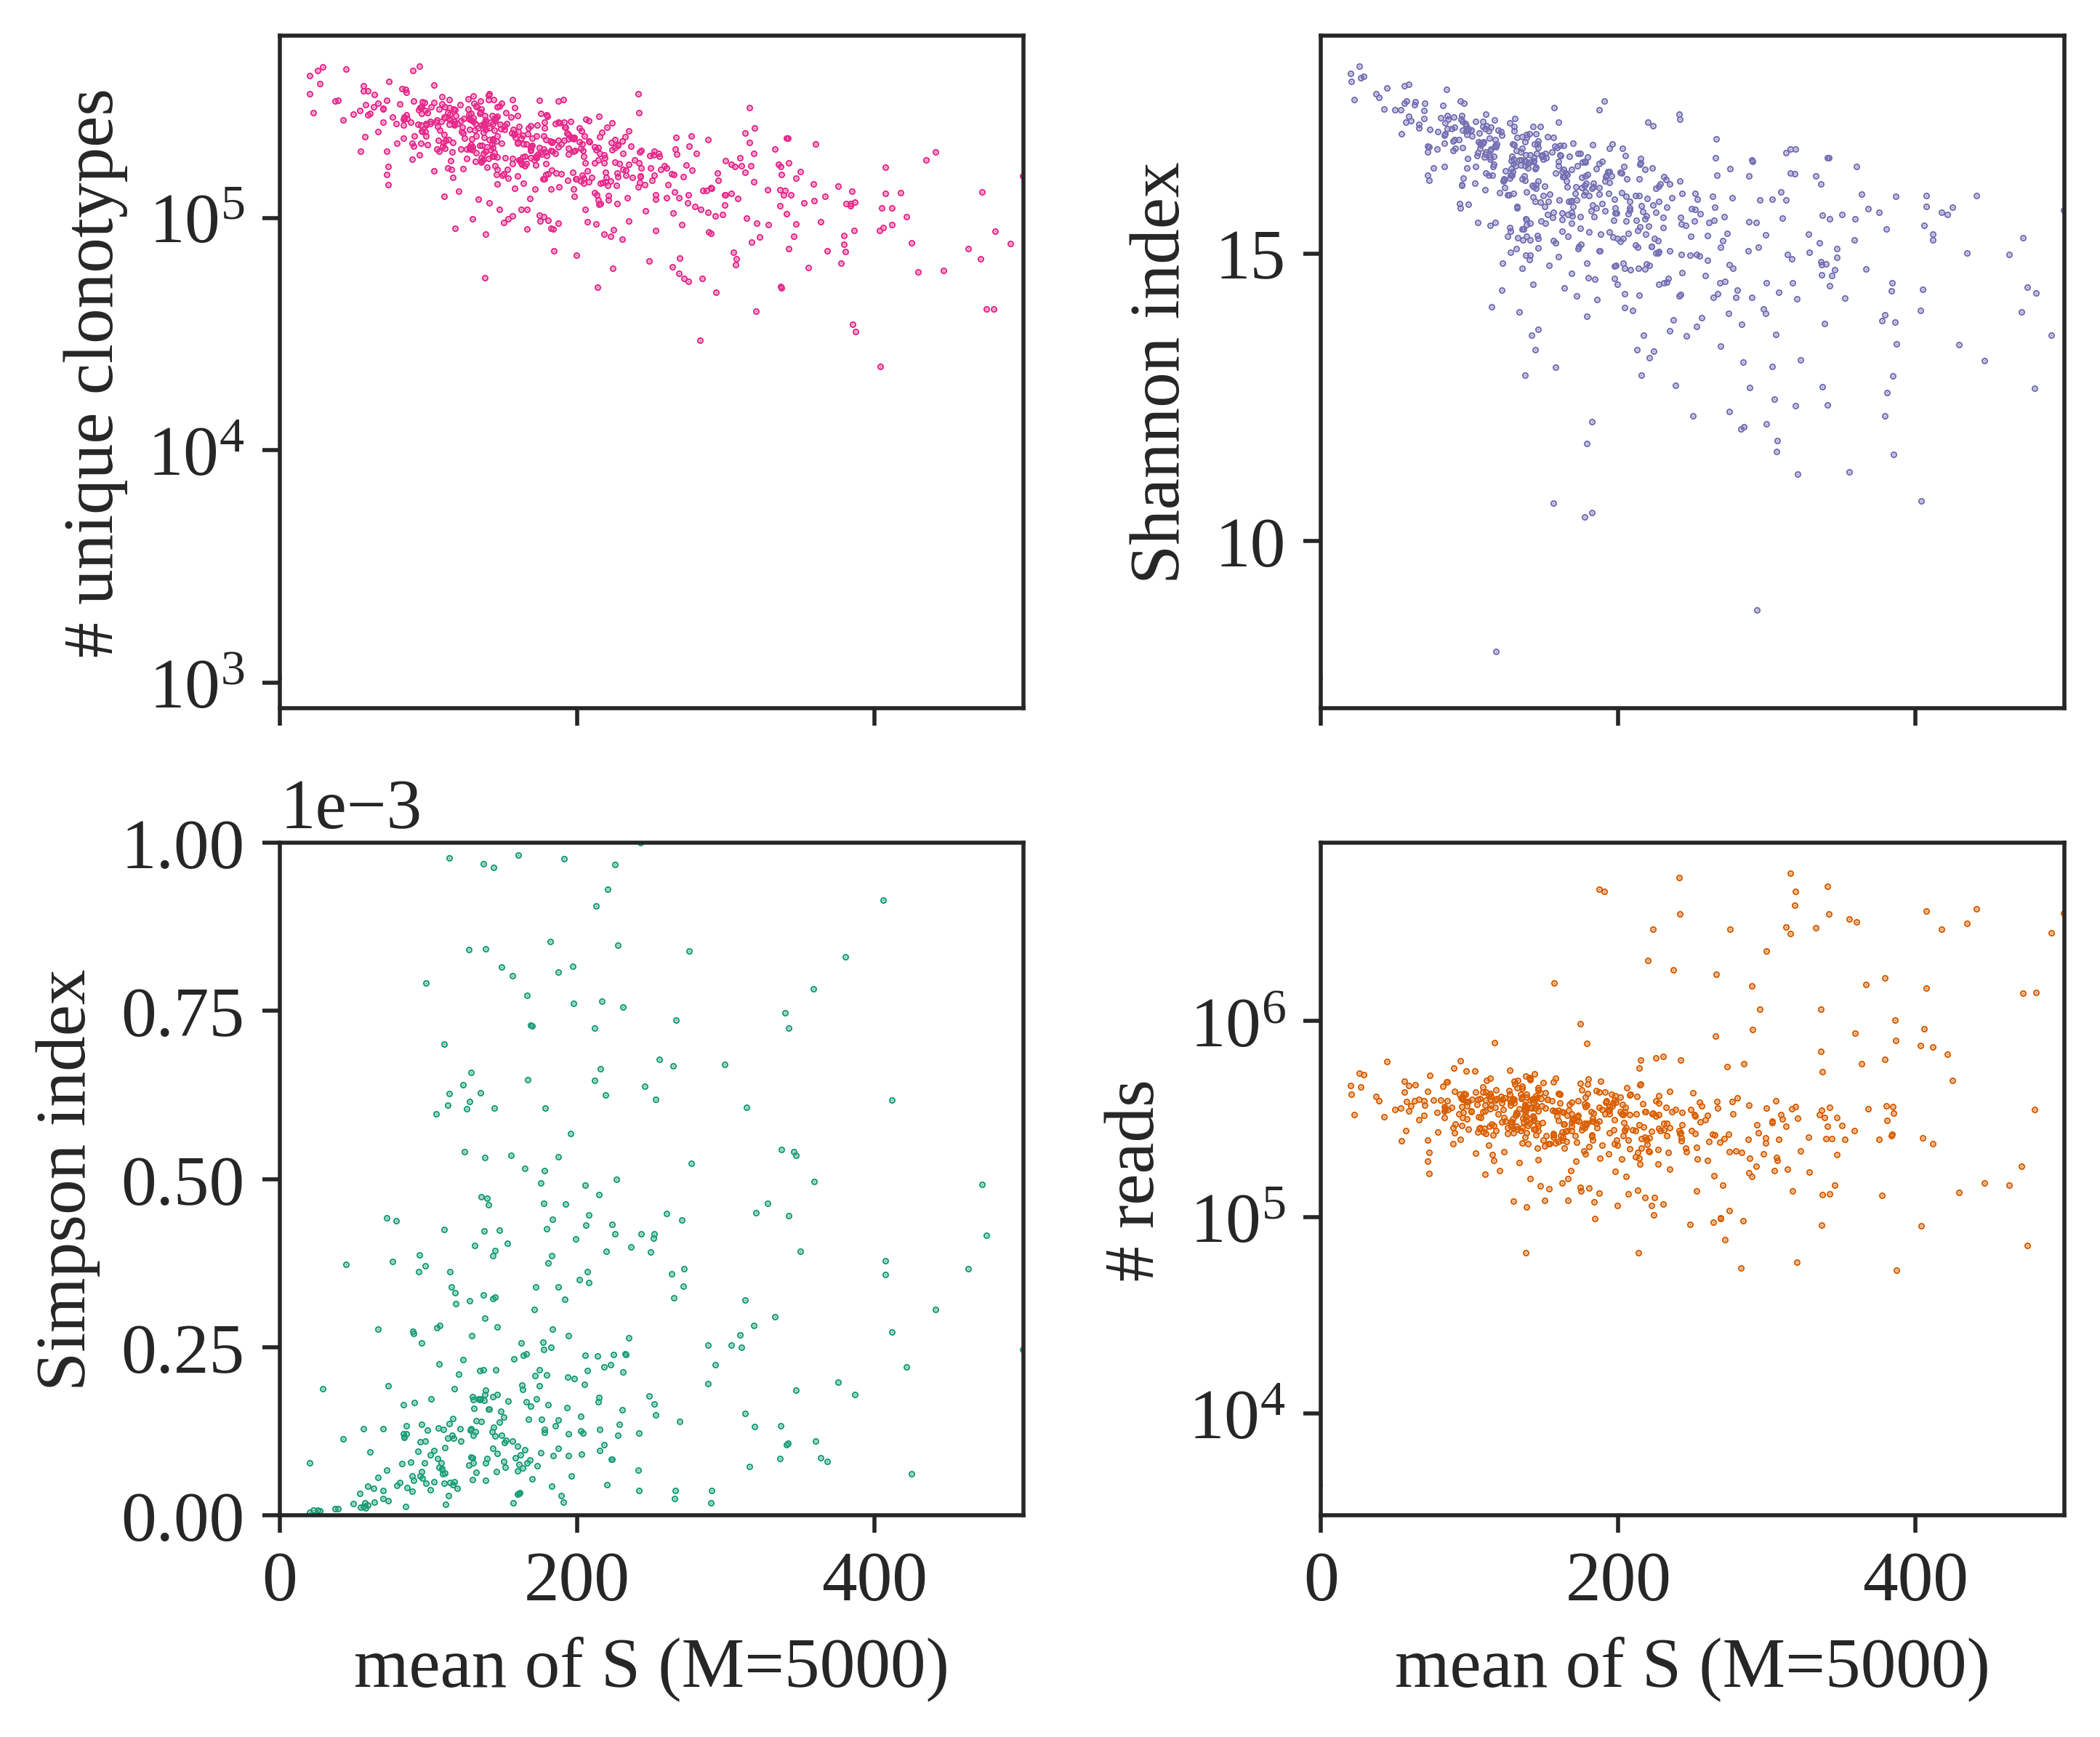

In [84]:
# Comparison between S & different diversity measure
with open("diversity_measure.pkl", "rb") as f:
    divmes = pickle.load(f)

sp = list(divmes['unique'].keys())
sp = [s for s in sp if divmes['S'][100][s] > -1]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6, 5), sharex=True)
flatui = ['#e7298a','#7570b3','#d95f02','#1b9e77']

pal = sns.color_palette(flatui)


ax1.scatter([divmes['S'][5000][s] for s in sp], 
            [divmes['unique'][s] for s in sp], s=0.1, color=pal[0])
ax2.scatter([divmes['S'][5000][s] for s in sp], 
            [divmes['shannon'][s] for s in sp], s=0.1, color=pal[1])
ax4.scatter([divmes['S'][5000][s] for s in sp], 
            [divmes['tot_reads'][s] for s in sp], s=0.1, color=pal[2])
ax3.scatter([divmes['S'][5000][s] for s in sp], 
            [divmes['simpson'][s] for s in sp], s=0.1, color=pal[3])
#ax1.set_xlabel("mean of S (M=5000)")
ax3.set_xlabel("mean of S (M=5000)")
ax1.set_ylabel("# unique clonotypes")
ax2.set_ylabel("Shannon index")
ax4.set_xlabel("mean of S (M=5000)")
ax4.set_ylabel("# reads")
ax3.set_ylabel("Simpson index")

ax1.set_yscale('symlog')
ax4.set_yscale('symlog')
ax3.set_ylim((0, 0.001))
ax3.set_xlim((0, 500))
ax3.ticklabel_format(style='sci', scilimits=(0, 0), axis='y')
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.savefig("SI_comparison_diversity_measure.pdf")
plt.show()

In [85]:
## slow

area_ROC_I_evoγ = []
γs = np.arange(-30, 0, 0.2)
M = 5000
for γ in tqdm(γs):
    area_ROC_I_evoγ.append(trpz_gmpy(
        [boundI2(r, M, meanS2=meanS2, 
           µp=(µp2+γ)/max(γ, µp2), σp=σp2/max(γ, µp2), maxM=50) for r in range(-1, M+1)],
        [boundI1(r, M, µp=(µp+γ)/max(γ, µp2), σp=σp/max(γ, µp2), maxM=50) for r in range(-1, M+1)]))

area_ROC_S_5000 =  ( 1 - 
        np.trapz(
            y=[1 - regularized_gamma_Q(r+1, meanS1(M)) for r in range(-1, M+1)][::-1],
            x=[1 - regularized_gamma_Q(r+1, meanS2(M)) for r in range(-1, M+1)][::-1]))


area_ROC_I_γ = []
γ = -15
Ms = np.arange(100, 8000, 100)
for M in tqdm(Ms):
    area_ROC_I_γ.append(trpz_gmpy(
        [boundI2(r, M, meanS2=meanS2, 
           µp=(µp2+γ)/max(γ, µp2), σp=σp2/max(γ, µp2), maxM=50) for r in range(-1, M+1)],
        [boundI1(r, M, µp=(µp+γ)/max(γ, µp2), σp=σp/max(γ, µp2), maxM=50) for r in range(-1, M+1)]))


area_ROC_I_0 = []
γ = 0
Ms = np.arange(100, 8000, 100)
for M in tqdm(Ms):
    area_ROC_I_0.append(trpz_gmpy(
        [boundI2(r, M, meanS2=meanS2, 
           µp=(µp2+γ)/max(γ, µp2), σp=σp2/max(γ, µp2), maxM=50) for r in range(-1, M+1)],
        [boundI1(r, M, µp=(µp+γ)/max(γ, µp2), σp=σp/max(γ, µp2), maxM=50) for r in range(-1, M+1)]))


<ipython-input-88-30c6ff63b4b3>:11: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_I_γ + [0]],


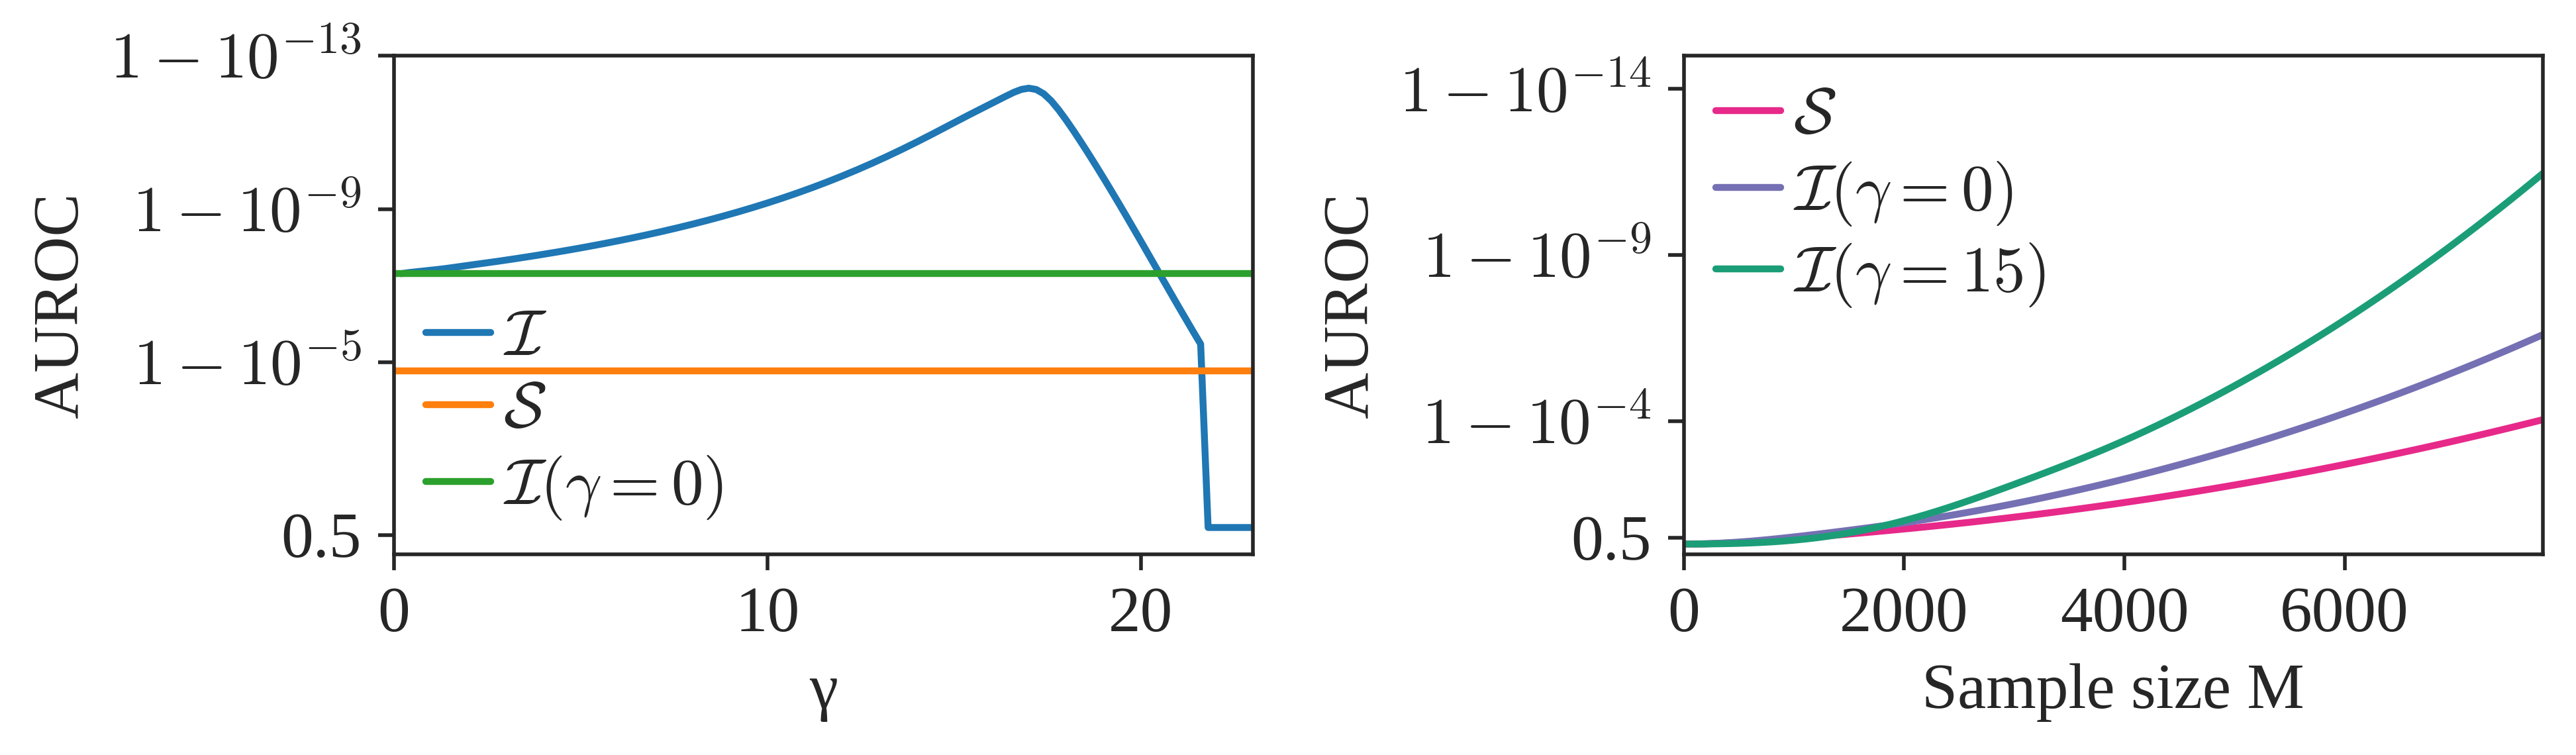

In [88]:
flatui = ['#e7298a','#7570b3','#d95f02','#1b9e77']
pal = sns.color_palette(flatui)

lw = 1.5
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(8, 2.5))

ax1.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_S[:]], linestyle='-',
        label=r"$\mathcal{S}$", color=pal[0], linewidth=lw)
ax1.plot(np.arange(100, 8000, 100), [-np.log10(float(v)) for v in area_ROC_I_0],
        label=r"$\mathcal{I} (\gamma = 0)$", color=pal[1], linewidth=lw)
ax1.plot(np.arange(1, 8000, 100), [-np.log10(float(v)) for v in area_ROC_I_γ + [0]],
        label=r"$\mathcal{I} (\gamma = 15)$", color=pal[3], linewidth=lw)

ax1.set_yticks([-a for a in range(-69, -3, 5)] + [0.5])
ax1.set_yticklabels([f"$1 - 10^{{{a}}}$" for a in range(-69, -3, 5)] + ["0.5"])
ax1.set_ylim(0., 15)
ax1.set_xlim(0, 7800)
ax1.legend(loc='upper left', frameon=False, handlelength=1,
          handletextpad=0.2, labelspacing=0.2, borderpad=0.)
ax1.set_ylabel(r"AUROC")
ax1.set_xlabel(r"Sample size M")


ax2.plot(-γs,np.array([-gmpy2.log(a) for a in area_ROC_I_evoγ]), label=r"$\mathcal{I}$")
ax2.plot([0., 30.], [-np.log(float(area_ROC_S_5000))]*2, label=r"$\mathcal{S}$")
ax2.plot([0., 30], [-np.log(float(area_ROC_I_evoγ[-1]))]*2, label=r"$\mathcal{I}(\gamma = 0)$")
ax2.set_ylabel("AUROC")
ax2.set_xlabel("γ")
ax2.set_yticks([-a for a in range(-69, -3, 4)] + [0.5])
ax2.set_yticklabels([f"$1 - 10^{{{a}}}$" for a in range(-69, -3, 4)] + ["0.5"])
ax2.set_ylim((0., 13))
ax2.set_xlim((0, 23))
ax2.legend(loc='lower left', frameon=False, handlelength=1,
          handletextpad=0.2, labelspacing=0.2, borderpad=0.)


plt.tight_layout()
plt.savefig("figSI_Igamma.pdf")
plt.show()